# Cart-pole swing-up problem: interactive demonstration

Hello and welcome. This is a Jupyter Notebook, a kind of document that can alternate between static content, like text and images, and executable cells of code.

This document ilustrates the Cart-pole swing-up test case of the paper: "Collocation Methods for Second Order Systems", submitted to RSS 2022.

In order to run the cells of code, you can select the cell and clic on the small "play" button in the bar above or press shift+enter. Alternatively, you can select the option "run -> run all cells" in order to run all the code in order. Beware that some cells can take several minutes!

All of the code used in this example is open-source and free to use.

[SymPy](https://www.sympy.org/en/index.html) is used for Symbolic formulation and manipulation of the problem.

[Numpy](https://numpy.org/) is used for numerical arrays and operations.

[CasADI](https://web.casadi.org/) is used for optimization.

[Chords](https://github.com/AunSiro/optibot) is the name of the package where we are compiling our code. We aim to produce a toolbox for Optimal Control Problems, focused on robotics, including a high level, readable and clean interface between the prior three packages.

## Package imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from matplotlib.patches import Rectangle

In [3]:
from sympy import (symbols, simplify, Matrix)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.physics.mechanics import Lagrangian, ReferenceFrame, Point, Particle,inertia, RigidBody

In [4]:
from casadi import mmax, sum1, sum2, jacobian

In [5]:
from chords.symbolic import lagrange, diff_to_symb, SimpLagrangesMethod
from chords.numpy import unpack

In [6]:
from functools import lru_cache
from copy import copy

In [7]:
#SymPy vector-like latex rendering inizialization:

init_vprinting()

In [8]:
from chords.util import (sch_to_lab, sch_to_color, sch_to_long_label, scheme_kwargs, oct_fig_size, set_fonts,
                        save_fig)
set_fonts()

## Symbolic Problem Modelling

The first step is to model our problem taking advantage of the high level object syntax of the mechanics module in SymPy

In [9]:
problem_name = 'Cartpole_ph'

In [10]:
# Creating symbols and dynamic symbols

m0, m1, l, t, g = symbols('m_0 m_1 l t g')
q0, q1 = dynamicsymbols('q_0 q_1')

In [11]:
# Definition of the physics system

N_in = ReferenceFrame('N')
pN = Point('N*')
pN.set_vel(N_in, 0)

P0 = pN.locatenew('P0', q0 * N_in.x)
P0.set_vel(N_in, q0.diff(t) * N_in.x)
cart_part = Particle('CartPart', P0, m0)
cart_part.potential_energy = m0 * g * P0.pos_from(pN).dot(N_in.y)

N1 = N_in.orientnew('N1', 'Axis', [q1, N_in.z])
P1 = P0.locatenew('P1', -l*N1.y)
P1.set_vel(N_in, P1.pos_from(pN).dt(N_in))

pend_part = Particle('PendPart', P1, m1)
pend_part.potential_energy = m1 * g * P1.pos_from(pN).dot(N_in.y)

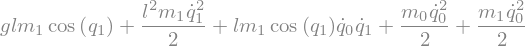

In [12]:
#Computing the Lagrangian

Lag_simp = Lagrangian(N_in, cart_part, pend_part)
Lag_simp

In [13]:
# Defining the control forces and external actions, and applying them to our system

u0, u1 = symbols('u_0, u_1')
FL = [(P0, u0 * N_in.x)]#, (N1, u1 * N_in.z)]
LM_small = SimpLagrangesMethod(Lag_simp, [q0, q1], forcelist=FL, frame=N_in)

Generating M_inv
simplifying M_inv
simplifying RHS
Model completed


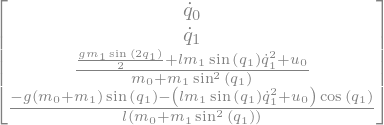

In [14]:
# Generating the dynamic equations

LM_small.form_lagranges_equations()
RHS_small = LM_small.rhs
RHS_small

### Casadi optimization

We have generated the system equations symbolicaly. Now, we translate them to CasADi objects in order to perform the optimization.

In [15]:
#Numerical values of the paramenters

m0_n, m1_n = [1., 0.3]
l_n = 0.5
g_n = 9.81
params = [g_n, l_n, m0_n, m1_n]

In [16]:
from chords.opti import Opti_Problem
from chords.analysis import interpolation, dynamic_errors
import time
from functools import lru_cache

# Translating the Sympy Expression into a CasADi function

F_cas_simp = rhs_to_casadi_function(RHS_small[2:], 2)

def gen_ini_guess(N = 25, ini_guess = 'lin'):
    '''
    Generates an initial guess for the Cartpole problem of N intervals.
    '''
    if ini_guess == 'zero':
        x_init_guess = np.zeros([N+1,4])
    elif ini_guess == 'lin':
        def_q1 = np.linspace(0,1,N+1)
        def_q2 = np.linspace(0,np.pi,N+1)
        def_v1 = np.zeros(N+1)
        def_v2 = np.zeros(N+1)
        x_init_guess = np.array([def_q1, def_q2, def_v1, def_v2]).T
    return x_init_guess


import time
def chrono_solve(opti, solve_repetitions):
    '''
    Calls the solver a certain amount of times and returns the last solution
    obtained and the average computing time
    '''
    cput0 = time.time()
    for ii in range(solve_repetitions):
        sol = opti.solve()
    cput1 = time.time()
    cpudt = (cput1-cput0)/solve_repetitions
    return sol, cpudt


In [17]:
tt_in = np.array([7.89876773e-04, 2.11306260e-01, 8.70550865e-01, 1.18073996e+00, 1.99921012e+00])
uu_in = np.array([  1.9055811 ,   8.9161864 , -13.86953442,   2.92946272, -1.85406161])
tt_in, uu_in

(array([7.89876773e-04, 2.11306260e-01, 8.70550865e-01, 1.18073996e+00,
        1.99921012e+00]),
 array([  1.9055811 ,   8.9161864 , -13.86953442,   2.92946272,
         -1.85406161]))

In [18]:
from chords.casadi import implicit_dynamic_x_to_casadi_function

In [19]:
x = dynamicsymbols('x_0:4')

In [20]:
x_d = [_i.diff() for _i in x]#symbols('\dot{x}_0:4')

In [21]:
RHSx=RHS_small.subs([
    [q0.diff(t), x[2]],
    [q1.diff(t), x[3]],
    [q0, x[0]],
    [q1, x[1]]
])

RHS_small,RHSx

In [22]:
x_d_mat = Matrix(x_d)

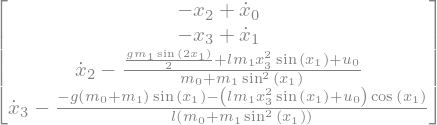

In [23]:
impl_D = x_d_mat-RHSx
impl_D

In [24]:
from chords.numpy import RHS2numpy
F_nump = RHS2numpy(RHS_small, 2)

Function Arguments:
	x: [q_0, q_1, v_0, v_1]
	u: [u_0]
	params: [g, l, m_0, m_1]



In [25]:
imp_F_x_cas = implicit_dynamic_x_to_casadi_function(impl_D, x, verbose=True)
imp_F_x_cas

x vars expected: [x_0, x_1, x_2, x_3, x_0_dot, x_1_dot, x_2_dot, x_3_dot]
x vars found: [x_0_dot, x_1, x_1_dot, x_2, x_2_dot, x_3, x_3_dot]
u vars found: [u_0]
Lambda variables are separated from parameters
lambda vars found: []
a variables are not separated from parameters
Parameters found: [g, l, m_0, m_1]
Function Arguments:
	x: [x_0, x_1, x_2, x_3]
	x_dot: [x_0_dot, x_1_dot, x_2_dot, x_3_dot]
	u: [u_0]
	lambdas: []
	params: [g, l, m_0, m_1]



Function(M:(x[4],x_dot[4],u,lambdas[0],params[4])->(residue[1x4]) MXFunction)

from chords.numpy import store_results

_opti = Opti_Problem(
        LM=imp_F_x_cas,
        params = params,
        scheme = 'ph_TD_LG',
        ini_guess= 'lin',
        t_end = 2,
        verbose=True,
        silent=False,
    )

_opti.scheme_mode

order = 2
_opti.dynamic_setup('f_x_impl', 4//order, 1, order = order)

t_knots_arr = [ 1,1.8]
point_structure = [7,6,4]
_opti.opti_setup(
            t_knots_arr,
            point_structure,
        )

solve_repetitions = 1

for sch_mode in ['TD_', 'BU_', '',]:#'TD_', 'BU_', ''
    for sch in ['LG', 'LG_inv', 'LGL', 'LGR', 'LGR_inv']:
        if sch_mode != '' and sch == 'LG_inv':
            continue
        scheme = f'ph_{sch_mode}{sch}'
        print(scheme)
        _opti = Opti_Problem(
            LM=imp_F_x_cas,
            params = params,
            scheme = scheme,
            ini_guess= 'lin',
            t_end = 2,
            verbose=False,
            silent=False,
        )
        print('\t', _opti.scheme_mode)
        _opti.dynamic_setup('f_x_impl', 4//order, 1, order = order)
        _opti.opti_setup(
            t_knots_arr,
            point_structure,
        )
        _opti.apply_scheme()
        _opti.u_sq_cost()
        if order == 2:
            _opti.initial_guess([0,0], [1,np.pi])
        elif order == 1:
            _opti.initial_guess([0,0, 0.5 ,np.pi/2], [1,np.pi, 0.5 ,np.pi/2])
        _opti.u_sq_cost()
        opti = _opti.opti
        X = _opti.opti_arrs['x']
        U_like_x = _opti.opti_arrs['u_like_x']
       # print(f'n_u: {_opti.n_u}, u shape: {U_like_x.shape}')
        X_s = _opti.opti_points['x_s']
        X_e = _opti.opti_points['x_e']
            
       # Initial and final conditions
        opti.subject_to(X_s.T == [0, 0, 0, 0])
        opti.subject_to(X_e.T == [1, np.pi, 0, 0])
        u_init = np.interp(_opti.opti_arrs['t'], tt_in, uu_in)
        opti.set_initial(U_like_x, u_init)
        
        # Appliying restrictions and action boundaries
        u_m = 20
        for ii in range(_opti.n_arr):
            opti.subject_to(opti.bounded(-u_m,U_like_x[ii,:],u_m))
        if _opti.scheme_mode == 'equispaced':
            opti.subject_to(opti.bounded(-u_m,U_like_x[-1, :],u_m))
            if 'parab' in scheme:
                U_c = _opti.opti_arrs['u_c']
                for ii in range(N):
                    opti.set_initial(U_c, (u_init[:-1] + u_init[1:])/2)
                    opti.subject_to(opti.bounded(-u_m,U_c[ii,:],u_m))
        try:
            _opti.chrono_solve(solve_repetitions=solve_repetitions,)
            print('----- SOLVED -----')

            plt.figure(figsize=oct_fig_size)
            plt.plot(_opti.results['t'], _opti.results['q'], marker = '.')
            plt.grid()
            plt.title('q ' + scheme)
            plt.plot(_opti.results['t_knot'], np.array(_opti.results['q_knot_list']), 'xk')

            #plt.figure(figsize=oct_fig_size)
            #plt.plot(_opti.results['t'], _opti.results['v'], marker = '.')
            #plt.grid()
            #plt.title('v ' + scheme)
            #plt.plot(_opti.results['t_knot'], np.array(_opti.results['v_knot_list']), 'xk')
            
            plt.figure(figsize=oct_fig_size)
            plt.plot(_opti.results['t_col'], _opti.results['u'], marker = '.')
            plt.grid()
            plt.title('u ' + scheme)
            plt.plot(_opti.results['t_knot'], np.array(_opti.results['u_knot_list']), 'xk')
            
        except:
            print('----- FAILED TO SOLVE -----')
        print('\n')
        #print(_opti.opti_lists['t_col'])

plt.figure(figsize=oct_fig_size)
plt.plot(_opti.results['t_col'], _opti.results['u'], marker = '.')
plt.grid()
plt.title(scheme)
plt.plot(_opti.results['t_knot'], np.array(_opti.results['u_knot_list']), 'xk')

_opti.results.keys()

for ii in range(_opti.results['n_coll_total']):
    print(_opti.dyn_f_restr(
        _opti.results['x_like_u'][ii,:],
        _opti.results['x_d_like_u'][ii,:],
        _opti.results['u'][ii],
        _opti.results['lam'][ii,:],
        params))

np.array(_opti.results['q_knot_list'])

_opti.opti.g

In [26]:
import importlib
import chords
importlib.reload(chords.util)
importlib.reload(chords.bu_pseudospectral)
importlib.reload(chords.td_pseudospectral)
importlib.reload(chords.pseudospectral)
importlib.reload(chords.opti)
importlib.reload(chords.analysis)
importlib.reload(chords)
from chords.opti import Opti_Problem
from chords.analysis import interpolation

In [27]:
waypoints_q = np.array([
    [0., 0.],
    [4, -2.],
    [0., 0.],
])
waypoints_x = np.array([
    [0., 0., 0., 0.],
    [2, -2., 6., -2.],
    [4, -2., 0., 0.],
    [2, -2., -6., 2.],
    [0., 0., 0., 0.],
])

params[-1] = 0.3

In [28]:
#@lru_cache(maxsize=None)
#@store_results
def casadi_cartpole(
    scheme,
    N = None,
    t_knots_arr = None,
    point_structure = None,
    ini_guess='lin',
    solve_repetitions = 1,
    t_end = 2,
    order = 2,
    verbose = False,
    silent = True,
    cost_obj = 'usq',
):
    _opti = Opti_Problem(
        LM=imp_F_x_cas,
        params = params,
        scheme = scheme,
        ini_guess= ini_guess,
        t_end = t_end,
        verbose=verbose,
        silent=silent,
    )
    _opti.dynamic_setup('f_x_impl', 4//order, 1, order = order)
    if 'ph_' in scheme:
        _opti.opti_setup(
                t_knots_arr,
                point_structure,
            )
        N = _opti.n_arr
    else:
        _opti.opti_setup(N)
    _opti.apply_scheme()
    
    if ini_guess == 'lin':
        if order == 2:
            _opti.initial_guess([0,0], [1,np.pi])
        elif order == 1:
            _opti.initial_guess([0,0, 0.5 ,np.pi/2], [1,np.pi, 0.5 ,np.pi/2])
    elif ini_guess == 'waypoints':
        if order == 2:
            _opti.initial_guess(waypoints_q)
        elif order == 1:
            _opti.initial_guess(waypoints_x)
    else:
        raise ValueError
        
    opti = _opti.opti
    X = _opti.opti_arrs['x']
    U = _opti.opti_arrs['u']
    U_like_x = _opti.opti_arrs['u_like_x']
    X_s = _opti.opti_points['x_s']
    X_e = _opti.opti_points['x_e']
    
    if cost_obj == 'usq':
        _opti.u_sq_cost()
    else:
        cost = sum1(X[:,0])
        _opti.cost = -cost
        opti.minimize(-cost)
    
        
   # Initial and final conditions
    opti.subject_to(X_s.T == [0, 0, 0, 0])
    if cost_obj == 'usq':
        opti.subject_to(X_e.T == [1, np.pi, 0, 0])
    else:
        opti.subject_to(X_e.T == [0, 0, 0, 0])
    u_init = np.interp(_opti.opti_arrs['t_col'], tt_in, uu_in)
    opti.set_initial(U, u_init)
    
    # Appliying restrictions and action boundaries
    u_m = 20
    for ii in range(U.shape[0]): #Esto no debería imponerse sólo en los collocation?
            opti.subject_to(opti.bounded(-u_m,U[ii,:],u_m)) #U_like_x
    if _opti.scheme_mode == 'equispaced':
        #opti.subject_to(opti.bounded(-u_m,U_like_x[-1, :],u_m))
        if 'parab' in scheme:
            U_c = _opti.opti_arrs['u_c']
            for ii in range(N):
                opti.set_initial(U_c, (u_init[:-1] + u_init[1:])/2)
                opti.subject_to(opti.bounded(-u_m,U_c[ii,:],u_m))
    
    
    _opti.chrono_solve(solve_repetitions=solve_repetitions,)
    sol = _opti.sol
    jac_mat = sol.value(jacobian(opti.g,opti.x)).toarray()
    
    _opti.results['sol'] = sol
    _opti.results['jac_mat'] = jac_mat
    _opti.results['opti_g'] = opti.g
    _opti.results['opti_x'] = opti.x
    
    return _opti.results

In [29]:
from chords.analysis import dynamic_errors
from chords.pseudospectral import tau_to_t_points, coll_points

In [30]:
def total_state_error(t_arr, dyn_err):
    errors = np.trapz(np.abs(dyn_err), t_arr, axis=0)
    return errors

In [31]:
scheme =  'trapz'# 'ph_LG'#'LG' #
n_col = 30
order = 1
t_knots_arr = [ 0.66, 1.33]
point_structure = [10, 10, 10]
_res = casadi_cartpole(
    scheme,
    N = n_col,
    t_knots_arr = t_knots_arr,
    point_structure = point_structure,
    ini_guess='waypoints',
    solve_repetitions=1,
    silent=True,
    verbose=False,
    order = order,
    cost_obj = 'usq'#'mm'#,
)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [32]:
n_interp = 1000
interpolations = interpolation(
            _res,
            problem_order = 2,
            scheme_order=2,
            x_interp=None,
            u_interp=None,
            n_interp=n_interp,
            #given_t_array=test_int_points
        )
q_arr = interpolations['q']
v_arr = interpolations['v']
u_arr = interpolations['u']
a_arr = interpolations['a']
t_interp = interpolations['t']

In [33]:
_res['opti_x'].shape

In [34]:
_res['jac_mat'].shape

In [35]:
save = True#False#
save_fmt = 'pdf'

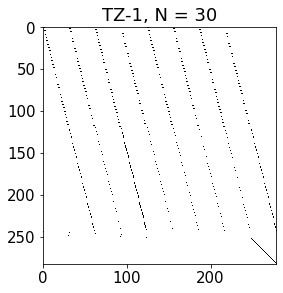

In [36]:
imsize = np.array(_res['jac_mat'].shape, dtype = 'float')/72
plt.figure(figsize=imsize, dpi = 72)
_aa = np.ones_like(_res['jac_mat'])
_aa[_res['jac_mat'] == 0] = 0
#plt.spy(_res['jac_mat'])
plt.imshow(_aa, cmap='Greys', interpolation = 'none')

if 'ph' in scheme:
    sch_name = 'patched ' + scheme.replace('ph_', '')
else:
    sch_name = sch_to_lab(scheme)

plt.imsave(f'sparsity{sch_name}.png', _aa, cmap='Greys')
plt.savefig('sparsity.pdf', dpi = 72)
plt.title(sch_name + f', N = {n_col}')
plt.tight_layout(pad = 0.0)
if save:
    save_fig(
        problem_name = problem_name,
        graph_name = 'sparsity',
        schemes_printed = [scheme],
        save_format = save_fmt,
        N = n_col,
        q_counter = None,
    )

In [37]:
np.sum(_aa)

In [38]:
np.mean(_aa)*100

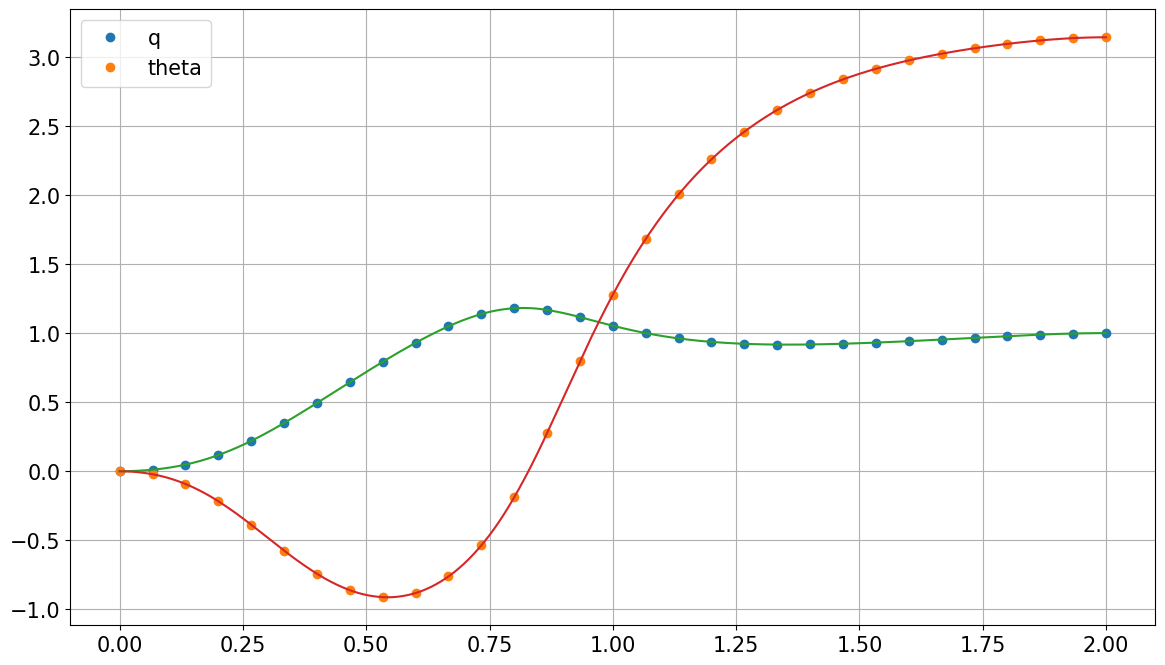

In [39]:
plt.figure(figsize=[14,8])
labels= ['q', 'theta']
for ii in range(2):
    plt.plot(_res['t'],_res['q'][:,ii], marker = 'o', ls = '', label = labels[ii])
    if 'parab' in _res['scheme']:
        plt.plot(_res['t_c'],_res['q_c'][:,ii], 'o', label = labels[ii] + '_c')
plt.plot(t_interp, q_arr)
plt.grid()
plt.legend()

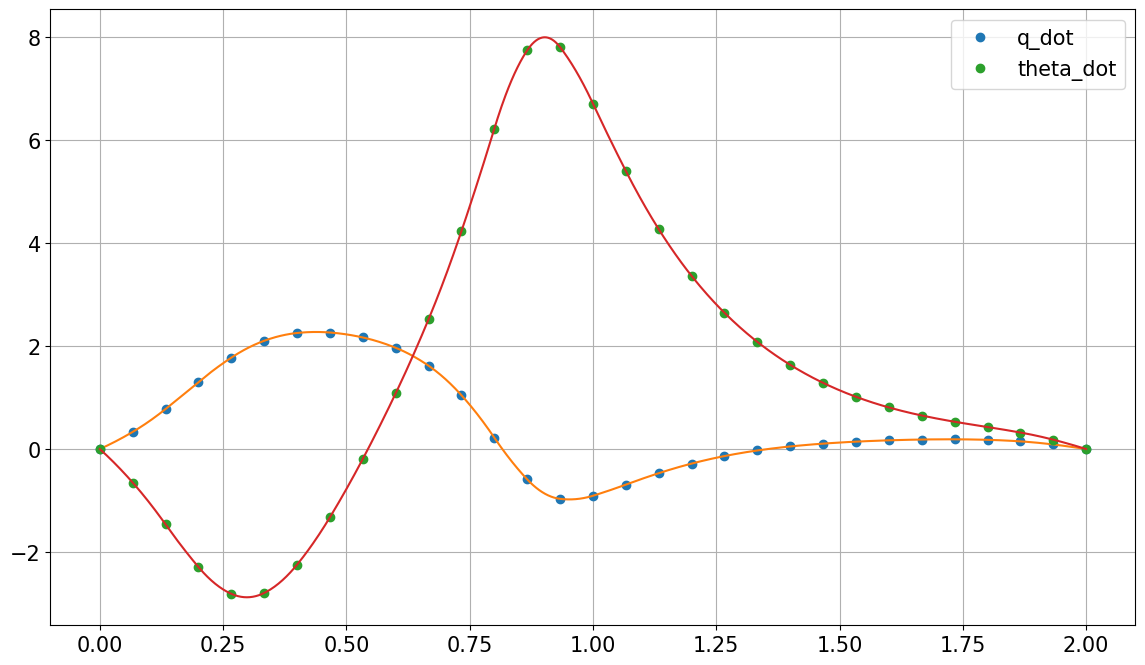

In [40]:
plt.figure(figsize=[14,8])
labels= ['q_dot', 'theta_dot']
v_res = _res['x'][:,2:]
for ii in range(2):
    plt.plot(_res['t'],v_res[:,ii], marker = 'o', ls = '', label = labels[ii])
    if 'parab' in _res['scheme']:
        plt.plot(_res['t_c'],_res['v_c'][:,ii], 'o', label = labels[ii] + '_c')
    plt.plot(t_interp, v_arr[:,ii])
plt.grid()
plt.legend()

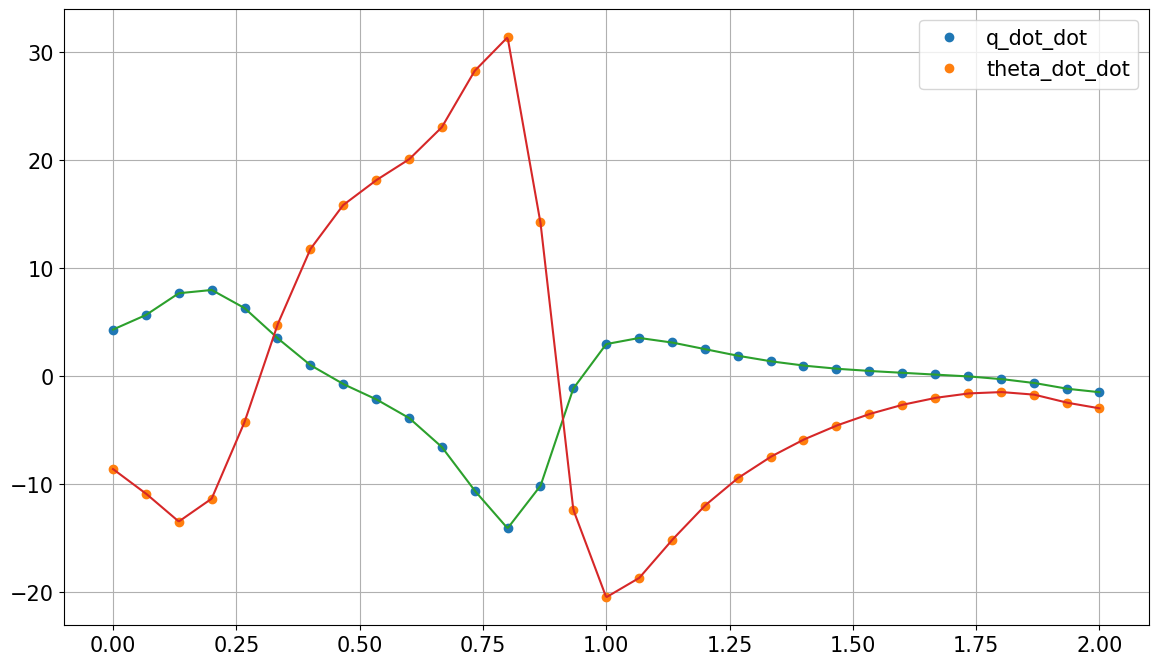

In [41]:
a_res = _res['x_d'][:,2:]
plt.figure(figsize=[14,8])
labels= ['q_dot_dot', 'theta_dot_dot']
for ii in range(2):
    plt.plot(_res['t'],a_res[:,ii], marker = 'o', ls = '', label = labels[ii])
    if 'parab' in _res['scheme']:
        a_res_c = _res['x_d_c'][:,2:]
        plt.plot(_res['t_c'],a_res_c[:,ii], 'o', label = labels[ii] + '_c')
plt.plot(t_interp, a_arr)
plt.grid()
plt.legend()

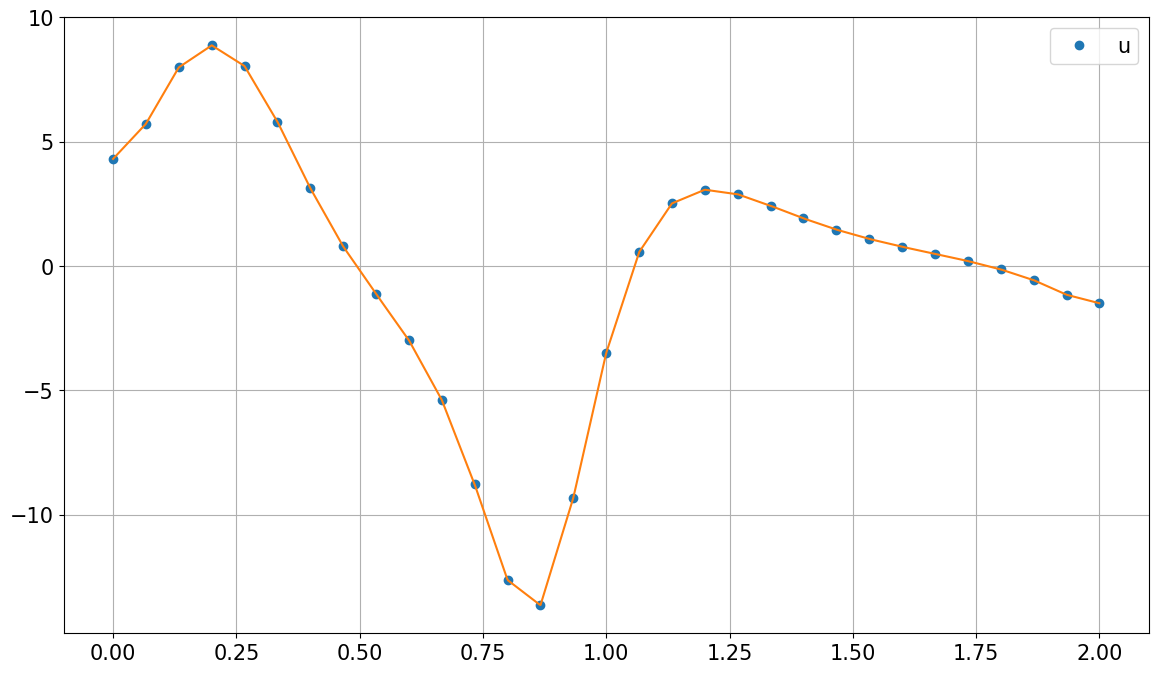

In [42]:
plt.figure(figsize=[14,8])
plt.plot(_res['t_col'],_res['u'][:], marker = 'o', ls = '', label = 'u')
plt.plot(t_interp, u_arr)
if 'parab' in _res['scheme']:
    plt.plot(_res['t_c'],_res['u_c'][:], 'o', label = 'u_c')
plt.grid()
plt.legend()

In [43]:
_dyn_errs = dynamic_errors(
    res = _res,
    F = F_nump,
    dynamics_error_mode='q',
    problem_order=2,
    scheme_order=2,
    x_interp=None,
    u_interp=None,
    n_interp=n_interp,
    save_in_res=True,
    #given_t_array=test_int_points,
)

In [44]:
total_state_error(t_interp,_dyn_errs['dyn_err_interp'])

array([0.82894189, 2.14516611])

In [45]:
test_int_points = [
    [0.1, 0.2, 0.5, 0.7],
    [0.8, 1, 1.3],
    [1.4, 1.9]
]
n_interp = 1000
n_col = 20
order = 2
t_knots_arr = [ 0.8,1.3]
point_structure = [15,15,15]
for sch_mode in ['TD_', 'BU_', '',]:#'TD_', 'BU_', ''
    for sch in ['LG', 'LG_inv', 'LGL', 'LGR', 'LGR_inv']:
        if sch_mode != '' and sch == 'LG_inv':
            continue
        scheme = f'ph_{sch_mode}{sch}'
        print(scheme)
        _res = casadi_cartpole(
            scheme,
            N = n_col,
            t_knots_arr = t_knots_arr,
            point_structure = point_structure,
            ini_guess='lin',
            solve_repetitions=1,
            silent=True,
            verbose=False,
            order = order
        )
        print('\t', _res['scheme_mode'])
        for ii in range(_res['n_segments']):
            print('\t',_res['x_d_knot_ext_list'][ii][:2]-_res['x_knot_ext_list'][ii][2:])

        interpolations = interpolation(
            _res,
            problem_order = 2,
            scheme_order=2,
            x_interp=None,
            u_interp=None,
            n_interp=n_interp,
            given_t_array=test_int_points
        )
        q_arr = interpolations['q']
        v_arr = interpolations['v']
        u_arr = interpolations['u']
        a_arr = interpolations['a']
        t_interp = interpolations['t']
        print('\n',t_interp-np.array([0.1, 0.2, 0.5, 0.7, 0.8, 1.  ,1.3, 1.4 ,1.9]))
        print('\n',q_arr-np.array([[-0.05982044, -0.17573488],
       [-0.02799908, -0.49405791],
       [ 0.37769889, -1.21506483],
       [ 0.6837041 , -0.86752372],
       [ 0.7712227 , -0.37222907],
       [ 0.67917925,  1.17624066],
       [ 0.64495038,  2.50997082],
       [ 0.67741966,  2.71698656],
       [ 0.91751666,  3.07393791]]))
        print('\n',)

ph_TD_LG
	 ph top-down pseudospectral
	 [0. 0.]
	 [0. 0.]
	 [0. 0.]

 [0. 0. 0. 0. 0. 0. 0. 0. 0.]

 [[ 0.03256307  0.2292645 ]
 [-0.04954728  0.63609131]
 [-0.32976471  0.93781974]
 [-0.2577102  -0.05746535]
 [-0.15012974 -0.67799864]
 [ 0.26085029 -1.8999941 ]
 [ 0.19327498 -1.17695853]
 [ 0.10708699 -0.83202188]
 [ 0.05570345  0.01312417]]


ph_TD_LGL
	 ph top-down pseudospectral
	 [ 4.22816225e-18 -3.52133014e-18]
	 [-1.11022302e-16  8.88178420e-16]
	 [-5.55111512e-17 -4.44089210e-16]

 [0. 0. 0. 0. 0. 0. 0. 0. 0.]

 [[ 0.03739121  0.21963073]
 [ 0.01889791  0.50319793]
 [ 0.2750224   0.14317452]
 [ 0.38414833 -0.26560917]
 [ 0.41586917 -0.44875559]
 [ 0.4465562  -0.58946429]
 [ 0.28009842 -0.21750438]
 [ 0.22940927 -0.15661106]
 [ 0.06766476  0.03746814]]


ph_TD_LGR
	 ph top-down pseudospectral
	 [0. 0.]
	 [0. 0.]
	 [0. 0.]

 [0. 0. 0. 0. 0. 0. 0. 0. 0.]

 [[0.07754006 0.14076746]
 [0.12549931 0.30906425]
 [0.31221133 0.31976809]
 [0.3949235  0.16128548]
 [0.40367118 0.10908771]


In [46]:
def calc_test_point_arr(res):
    new_point_str = res['point_structure'] +1
    sch = res['scheme'].replace("ph_", "").replace("TD_", "").replace("BU_", "")
    limits = res['t_knot_ext']
    n_seg = res['n_segments']
    t_list = []
    for seg_ii in range(n_seg):
        t0 = limits[seg_ii]
        t1 = limits[seg_ii+1]
        N = new_point_str[seg_ii]
        t_list.append(np.array(tau_to_t_points(coll_points(N, sch), t0, t1), dtype = "float64"))
    return t_list

In [47]:
def analyze_res_err(res, F, save_in_res=True):
    new_point_str = res['point_structure'] +1
    sch = res['scheme']
    limits = res['t_knot_ext']
    n_seg = res['n_segments']
    test_points_arr = calc_test_point_arr(res)
    _err = dynamic_errors(
        res = res,
        F = F,
        dynamics_error_mode='q',
        problem_order=2,
        scheme_order=2,
        x_interp=None,
        u_interp=None,
        n_interp=None,
        save_in_res=save_in_res,
        given_t_array=test_points_arr,
    )
    dyn_err = _err['dyn_err_interp']
    t_err = np.concatenate(test_points_arr)
    dyn_err_list = []
    arr_index = 0
    for seg_ii in range(n_seg):
        int_len = new_point_str[seg_ii]
        dyn_err_list.append(
            dyn_err[arr_index:arr_index+int_len]
        )
        arr_index += int_len
    if save_in_res:
        res['error']['t_err'] = t_err
        res['error']['t_err_list'] = test_points_arr
        res['error']['dyn_err_interp_list'] = dyn_err_list
    return test_points_arr, dyn_err_list

In [48]:
def max_err(res):
    n_seg = res['n_segments']
    err_list = res['error']['dyn_err_interp_list']
    test_points_arr = res['error']['t_err_list'] 
    interpolations = interpolation(
        res,
        problem_order = 2,
        scheme_order=2,
        x_interp=None,
        u_interp=None,
        n_interp=None,
        save_in_res= False,
        given_t_array=test_points_arr
    )
    a_list = interpolations['a_list']
    a_list_max = [np.max(np.abs(_aa), axis=0) for _aa in a_list]
    a_list_max = np.array(a_list_max, dtype = 'float64')
    res['error']['max_a'] = a_list_max
    max_err_list = []
    for seg_ii in range(n_seg):
        max_err_list.append(
            np.max(np.abs(err_list[seg_ii]), axis=0)
        )
    max_err_list = np.array(max_err_list, dtype = 'float64')
    res['error']['max_abs_err'] = max_err_list
    max_err_rel = max_err_list / (1+a_list_max)
    rel_err_list = [rr / (1+a_list_max[ii]) for ii, rr in enumerate(err_list)]
    res['error']['rel_err_list'] = rel_err_list
    res['error']['max_rel_err'] = np.max(max_err_rel, axis = 1).flatten()
    return max_err_rel

In [49]:
def log_base(x, base):
    aa = np.log(x)
    bb = np.log(base)
    return aa/bb

In [50]:
def add_points(res, epsilon, allow_neg = False):
    m_err = res['error']['max_rel_err']
    rel_err_quot = m_err/epsilon
    add_arr = np.int_(np.ceil(log_base(rel_err_quot, res['point_structure'])))
    if not allow_neg:
        add_arr = np.maximum(add_arr, 0)
    res['add_p'] = add_arr
    return add_arr

In [51]:
def calc_new_struct(min_p, max_p, p_str, add_p, t_knot_ext):
    p_str = np.array(p_str, dtype = 'int')
    add_p = np.array(add_p, dtype = 'int')
    t_knot_ext = np.array(t_knot_ext, dtype = 'float64')
    assert p_str.shape == add_p.shape
    n_seg = len(p_str)
    n_p_str = p_str + add_p
    new_t_knot_ext = [t_knot_ext[0],]
    new_p_str =[]
    for seg_ii in range(n_seg):
        new_n = n_p_str[seg_ii]
        min_t = t_knot_ext[seg_ii]
        max_t = t_knot_ext[seg_ii+1]
        if new_n <= max_p:
            new_p_str.append(new_n)
            new_t_knot_ext.append(max_t)
        else:
            div_n = int(np.ceil(new_n/max_p))
            new_n_each = int(np.ceil(new_n/div_n))
            new_n_each = max(new_n_each, min_p)
            new_knots = np.linspace(min_t, max_t, div_n+1)[1:]
            new_t_knot_ext += list(new_knots)
            new_p_str += [new_n_each,] * div_n
    new_t_knots = np.array(new_t_knot_ext[1:-1], dtype = 'float64')
    new_point_structure = np.array(new_p_str, dtype = 'int')
    return new_t_knots, new_point_structure

In [52]:
def plot_adp_ref_table(_res):
    plt.figure(figsize=oct_fig_size)
    _N = _res['n_coll_total']
    plt.title(f'Adaptive refinement, iteration {_res["iteration"]}')
    plt.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            left = False,
            labelleft = False,
            labelbottom=False)

    plt.xlim(0,2)
    plt.ylim(0.3,2)

    add_p = _res['add_p']
    interv_centers = (_res['t_knot_ext'][:-1]+_res['t_knot_ext'][1:])/2
    point_n = _res['point_structure'] + add_p

    plt.text(
        1,
        1.8,
        'Current iteration structure:',
        ha = 'center'
    )

    for ii in range(_res['n_segments']):
        plt.text(
            interv_centers[ii],
            1.6,
            f'$N_{ii+1}=$' + str(_res['point_structure'][ii]),
            ha = 'center'
        )

        h_text = _res['t_knot_ext'][ii+1] - _res['t_knot_ext'][ii]
        if h_text>0.3:
            eps_txt_size = 15
        else:
            eps_txt_size = 12.3

        c_item = 'k' if add_p[ii] > 0 else 'g'

        plt.text(
            interv_centers[ii],
            1.4,
            f"$\epsilon_{ii+1}=$ { _res['error']['max_rel_err'][ii]:.1e}",
            ha = 'center',
            size = eps_txt_size,
            c = c_item,
        )
        plt.text(
            interv_centers[ii],
            1.2,
            f'$P_{ii+1}=$' + str(add_p[ii]),
            ha = 'center',
            c = c_item
        )
        if np.max(add_p) > 0:
            plt.text(
                interv_centers[ii],
                1.0,
                f'$N_{ii+1}^+=$' + str(point_n[ii]),
                ha = 'center',
                c = 'r' if point_n[ii] > N_max else c_item
            )

    if np.max(add_p) == 0:
        plt.vlines(
            _res['t_knot'],
            1.2,
            1.7,
            color = 'k',
            ls = ':',
        )
        plt.plot(
            [0.6, 0.6, 1.4, 1.4, 0.6],
            [0.7, 0.95, 0.95, 0.7, 0.7],
            c = 'g'
        )
        plt.text(
            1,
            0.8,
            'Convergence reached',
            ha = 'center',
            c = 'g'
        )
    else:
        new_t_knots = _res['new_t_knots']
        new_point_structure = _res['new_point_structure']
        plt.vlines(
            _res['t_knot'],
            0.95,
            1.7,
            color = 'k',
            ls = ':',
        )
        #  --- 

        plt.text(
            1,
            0.8,
            'Next iteration structure:',
            ha = 'center'
        )

        plt.vlines(
            new_t_knots,
            0.3,
            0.7,
            color = 'k',
            ls = ':',
        )
        new_t_k_ext = np.concatenate(([0.], new_t_knots, [2.]))
        new_interv_centers = (new_t_k_ext[:-1]+new_t_k_ext[1:])/2
        for ii in range(len(new_point_structure)):
            plt.text(
                new_interv_centers[ii],
                0.5,
                f'$N_{ii+1}=$' + str(new_point_structure[ii]),
                ha = 'center'
            )
    plt.tight_layout(pad = 0.0)
    if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'ph_adp_refin',
            schemes_printed = [_res['scheme']],
            save_format = save_fmt,
            N = '',
            q_counter = None,
            add=f'iter_{_res["iteration"]}'
        )

In [53]:
def plot_rel_err(_res):
    plt.figure(figsize=oct_fig_size)

    err_max = np.max(_res['error']['max_rel_err'])
    err_min = np.min([
        np.min(np.abs(ii)) for  ii in _res['error']['rel_err_list']
    ])
    y_max = np.max([err_max, epsilon]) * 4
    y_min = np.min([err_min, epsilon]) * 0.25
    plt.ylim(y_min, y_max)

    _N = _res['n_coll_total']
    _ms = 90/(_N**(0.7)+6)

    plt.title(f'Relative errors, iteration {_res["iteration"]}, N = {_N}')

    for ii in range(_res['n_segments']):
        for jj in range(2):
            plt.plot(
                _res['error']['t_err_list'][ii],
                np.abs(_res['error']['rel_err_list'][ii][:,jj]),
                'o',
                ms = _ms,
                c = f'C{jj}',
                label = f'rel err $q_{jj+1}$' if ii==0 else ''
            )
        plt.hlines(
            _res['error']['max_rel_err'][ii],
            _res['t_knot_ext'][ii],
            _res['t_knot_ext'][ii+1],
            ls = '--',
            color = 'r',
            label = r'$\varepsilon_k$' if ii==0 else ''
        )
    plt.vlines(
        _res['t_knot'],
        y_min,
        y_max,
        color = 'k',
        ls = ':',
        label = 'knot points' if np.array(_res['t_knot']).shape != (0,) else '',
        lw = 2
    )
    plt.vlines(
        [0,2],
        y_min,
        y_max,
        color = 'k',
        ls = '-',
        lw = 2
    )
    plt.hlines(
        epsilon,
        0,
        2,
        color = 'g',
        ls = '--',
        label = r'$ϵ$'
    )
    plt.grid()
    plt.yscale('log')
    plt.legend()

    plt.tight_layout(pad = 0.0)
    if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'ph_rel_err',
            schemes_printed = [_res['scheme']],
            save_format = save_fmt,
            N = '',
            q_counter = None,
            add=f'iter_{_res["iteration"]}'
        )

### Ejemplo

In [54]:
scheme = 'ph_BU_LG'
n_col = 10
order = 2
t_knots_arr = [ ]
point_structure = [10,]
N_max = 25
N_min = 3
_res = casadi_cartpole(
    scheme,
    N = n_col,
    t_knots_arr = t_knots_arr,
    point_structure = point_structure,
    ini_guess='lin',
    solve_repetitions=1,
    silent=True,
    verbose=False,
    order = order
)
iter_ii = 1
_res['iteration'] = iter_ii

In [55]:
_ = analyze_res_err(_res, F_nump)

In [56]:
max_err(_res)

array([[0.53668142, 0.63428158]])

In [57]:
epsilon = 1e-9
max_err(_res)
add_p = add_points(_res, epsilon)
add_p

array([9])

In [58]:
new_t_knots, new_point_structure = calc_new_struct(N_min, N_max , point_structure, add_p, _res['t_knot_ext'])
new_t_knots, new_point_structure

(array([], dtype=float64), array([19]))

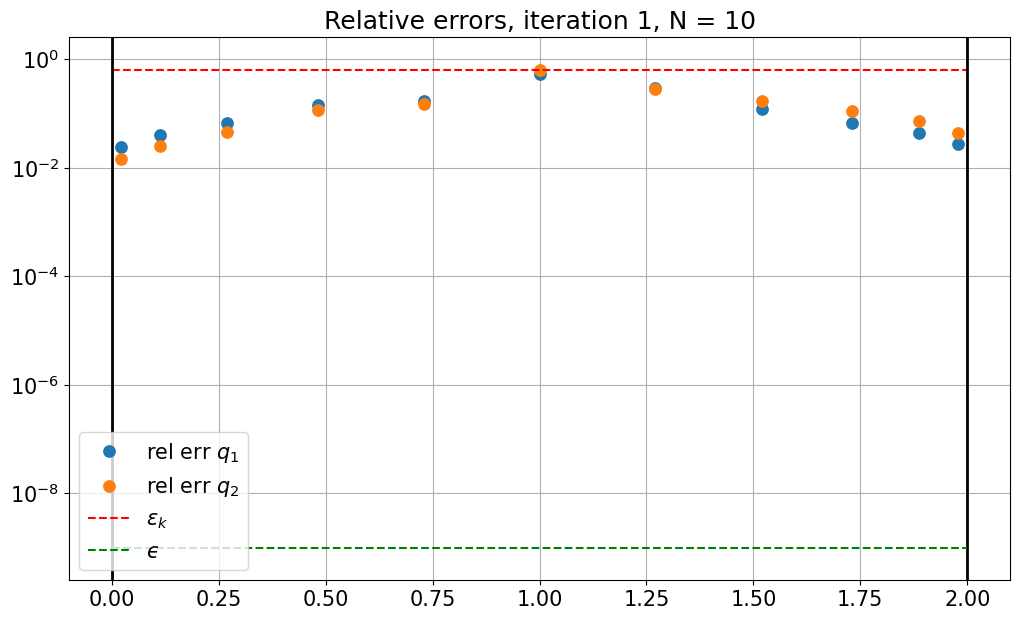

In [59]:
plot_rel_err(_res)

In [60]:
point_structure = new_point_structure
iter_ii += 1
_res = casadi_cartpole(
    scheme,
    N = n_col,
    t_knots_arr = new_t_knots,
    point_structure = point_structure,
    ini_guess='lin',
    solve_repetitions=1,
    silent=True,
    verbose=False,
    order = order
)
_res['iteration'] = iter_ii
print('iteration: ', iter_ii)

iteration:  2


In [61]:
_ = analyze_res_err(_res, F_nump)

In [62]:
max_err(_res)
add_p = add_points(_res, epsilon)
new_t_knots, new_point_structure = calc_new_struct(N_min, N_max , point_structure, add_p, _res['t_knot_ext'])
_res['new_t_knots'] = new_t_knots
_res['new_point_structure'] = new_point_structure
add_p, new_t_knots, new_point_structure

(array([7]), array([1.]), array([13, 13]))

In [63]:
save = True#False#
save_fmt = 'pdf'

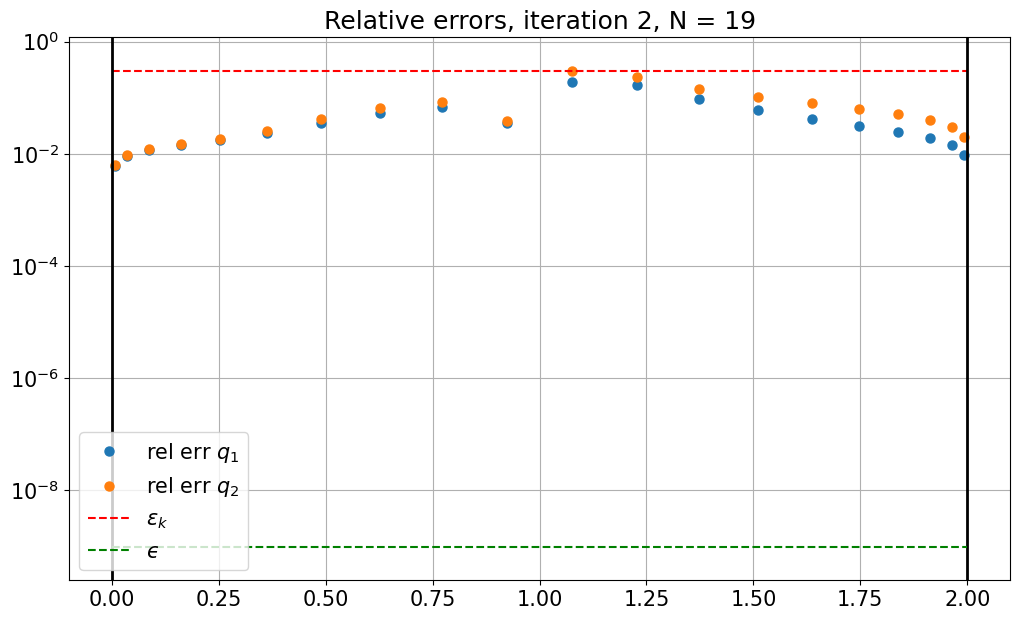

In [64]:
plot_rel_err(_res)

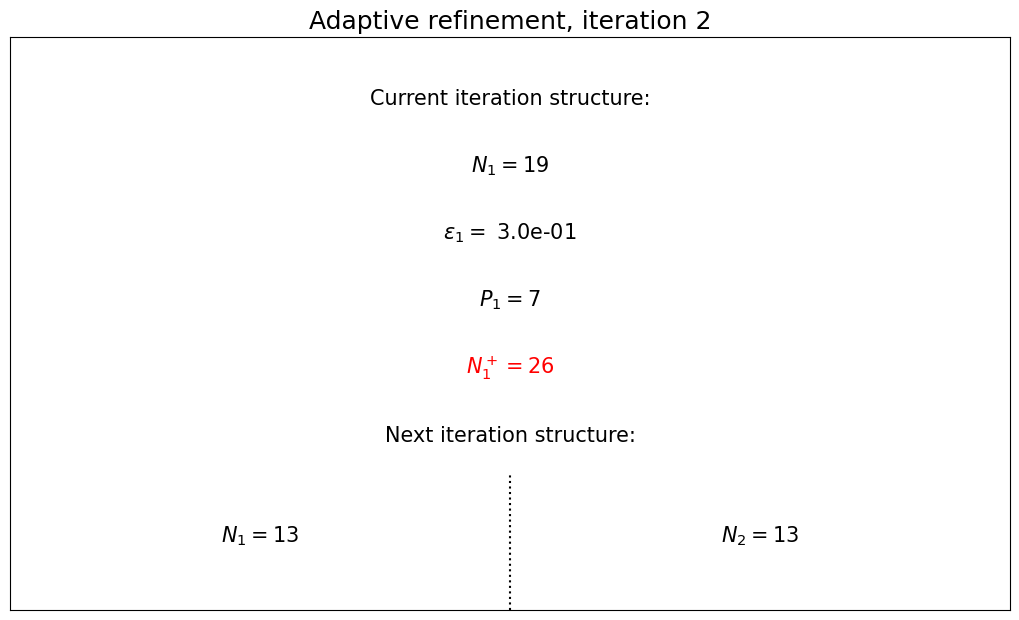

In [65]:
plot_adp_ref_table(_res)

# Adaptive refinement

In [66]:
def adaptive_refinement_system(
    problem,
    F,
    scheme,
    order = 2,
    problem_kwargs = None,
    initial_t_knots = None,
    initial_point_structure = np.array([10]),
    min_p = 3,
    max_p = 25,
    epsilon = 1e-9,
    max_iter = 100,
    max_coll_points = 500,
    silent = False,
):

    ph_run = []
    point_structure = np.array(initial_point_structure, dtype = 'int')
    if initial_t_knots is None:
        t_knots = np.array([], dtype = 'int')
    else:
        t_knots = initial_t_knots

    if problem_kwargs is None:
        problem_kwargs = {
            'ini_guess':'lin',
            'solve_repetitions':1,
            'silent':True,
            'verbose':False,
        }
        
    for iter_ii in range(max_iter):
        N = np.sum(point_structure)
        if not silent:
            print(f'iter: {iter_ii+1}, t_knots: {t_knots}, point_structure: {point_structure}', time.strftime('%H:%M:%S ', time.localtime(time.time())))
        try:
            _res = problem(
                scheme,
                N = N,
                t_knots_arr = t_knots,
                point_structure = point_structure,
                order = order
            )
        except RuntimeError:
            point_structure = point_structure + 1
            if not silent:
                print('attempt failed, tring again')
            continue
        t_err_list, err_list = analyze_res_err(_res, F)
        max_err_rel = max_err(_res)
        print(f'\tMax rel err: {max_err_rel}')
        add_p = add_points(_res, epsilon)
        _res['iteration'] = iter_ii + 1
        
        if np.max(max_err_rel) < epsilon:
            print('Convergencia Alcanzada!')
            ph_run.append(_res)
            break
        
        if not silent:
            print(f'\tadditional points: {add_p}')
        t_knots, point_structure = calc_new_struct(min_p, max_p , point_structure, add_p, _res['t_knot_ext'])
        _res['new_t_knots'] = t_knots
        _res['new_point_structure'] = point_structure
        if np.sum(point_structure) > max_coll_points:
            print('Máximo número de collocation points Alcanzado!')
            ph_run.append(_res)
            break
        ph_run.append(_res)

    return ph_run
        

In [67]:
def analyze_ph_run(ph_run, F, n_interp = 2000):
    t_arr = np.linspace(0,2, n_interp)
    _c = []
    _cpudt = []
    _iters = []
    _err_2 = []
    _err_q = []
    _N = []
    for case in ph_run:
        _c.append(case['cost'])
        _cpudt.append(case['cpudt'])
        _iters.append(case['iteration'])
        _N.append(case['n_coll_total'])
        _errors = dynamic_errors(
                case,
                F,
                dynamics_error_mode = 'q',
                problem_order=2,
                scheme_order=2,
                x_interp=None,
                u_interp=None,
                n_interp=n_interp,
            )
        dyn_err_2 = _errors['dyn_err_interp']
        dyn_err_q = _errors['compat_err_1_interp']
        tot_dyn_err_2 = total_state_error(t_arr, dyn_err_2)
        tot_dyn_err_q = total_state_error(t_arr, dyn_err_q)
        _err_2.append(tot_dyn_err_2)
        _err_q.append(tot_dyn_err_q)
    results= {
        'cost': np.array(_c),
        'cpudt': np.array(_cpudt),
        'iterations': np.array(_iters),
        'err_2_acum': np.array(_err_2),
        'err_q_acum': np.array(_err_q),
        'N_arr': np.array(_N),
    }
    return results

In [68]:
scheme = 'ph_TD_LG'
ph_run = adaptive_refinement_system(
    problem = casadi_cartpole,
    F = F_nump,
    scheme = scheme,
    order = 2,
    problem_kwargs = None,
    initial_t_knots = None,
    initial_point_structure = np.array([10]),
    min_p = 3,
    max_p = 25,
    epsilon = 1e-9,
    max_iter = 100,
    max_coll_points = 250,
)

iter: 1, t_knots: [], point_structure: [10] 20:17:14 
	Max rel err: [[0.53668142 0.63428158]]
	additional points: [9]
iter: 2, t_knots: [], point_structure: [19] 20:17:14 
	Max rel err: [[0.19242814 0.29879968]]
	additional points: [7]
iter: 3, t_knots: [1.], point_structure: [13 13] 20:17:14 
	Max rel err: [[0.00523909 0.00774483]
 [0.00951204 0.02323531]]
	additional points: [7 7]
iter: 4, t_knots: [1.], point_structure: [20 20] 20:17:15 
	Max rel err: [[0.00040507 0.00046453]
 [0.00425113 0.00507954]]
	additional points: [5 6]
iter: 5, t_knots: [1.  1.5], point_structure: [25 13 13] 20:17:16 
	Max rel err: [[3.75326640e-04 7.36192059e-04]
 [2.39738413e-03 3.09586144e-03]
 [8.28807566e-05 2.39634019e-04]]
	additional points: [5 6 5]
iter: 6, t_knots: [0.5 1.  1.5], point_structure: [15 15 19 18] 20:17:17 
	Max rel err: [[8.42100677e-07 1.85449914e-06]
 [7.73290500e-06 1.76726628e-05]
 [2.06159856e-04 2.42065816e-04]
 [1.01697951e-05 3.08870615e-05]]
	additional points: [3 4 5 4]
iter

/var/folders/zr/77h_h1jj5c3bsmnltbw6p0s40000gq/T/ipykernel_5528/230389288.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=oct_fig_size)


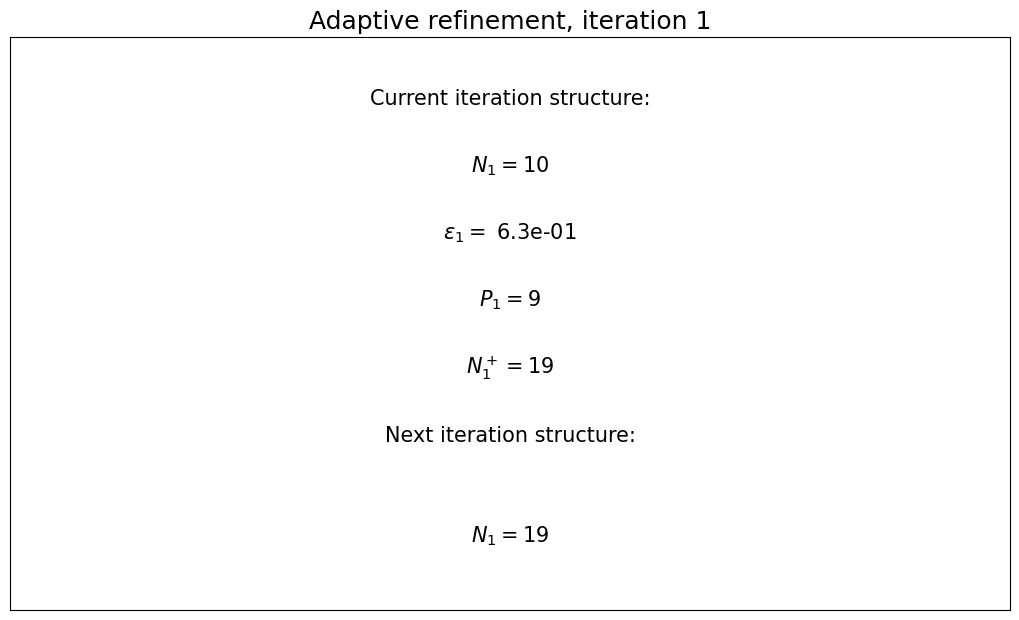

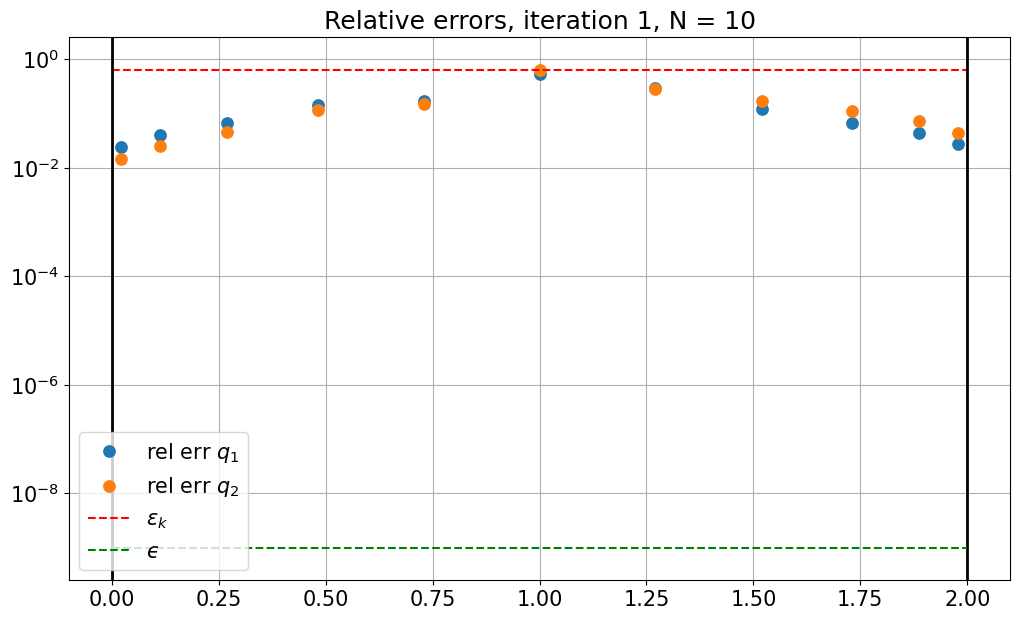

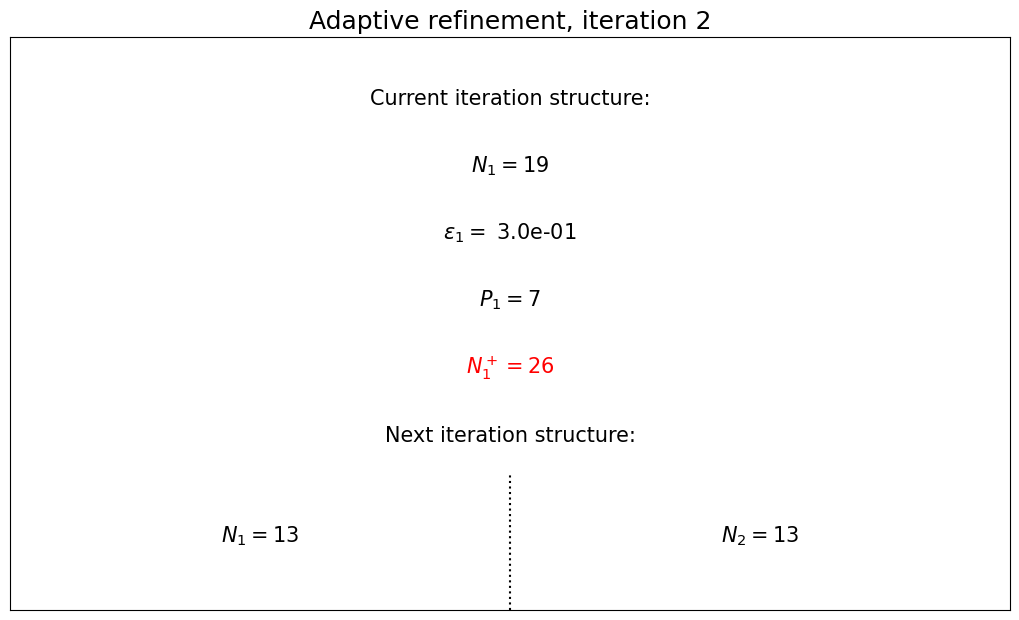

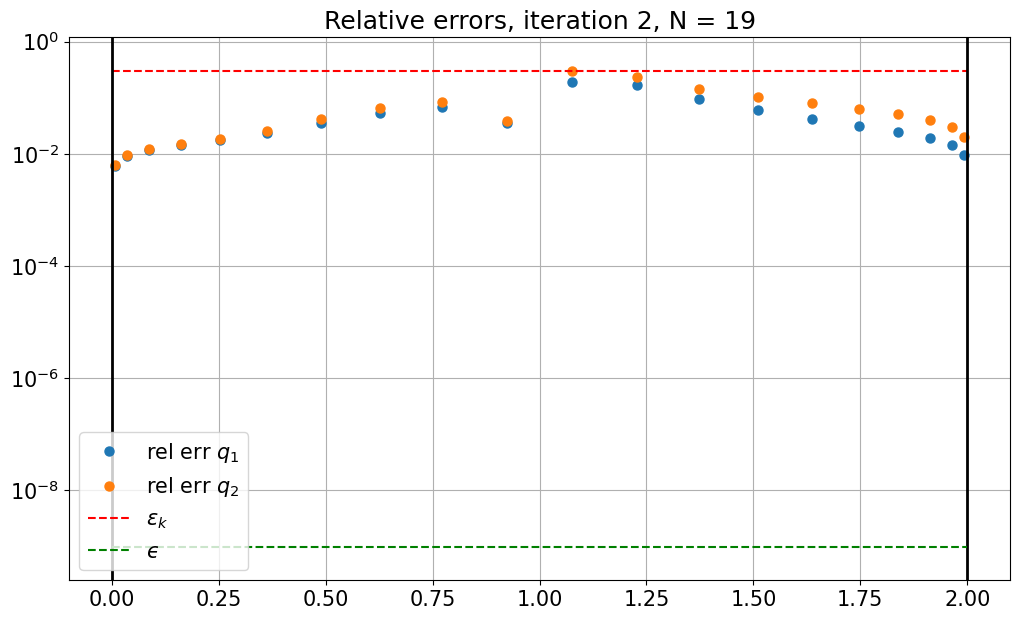

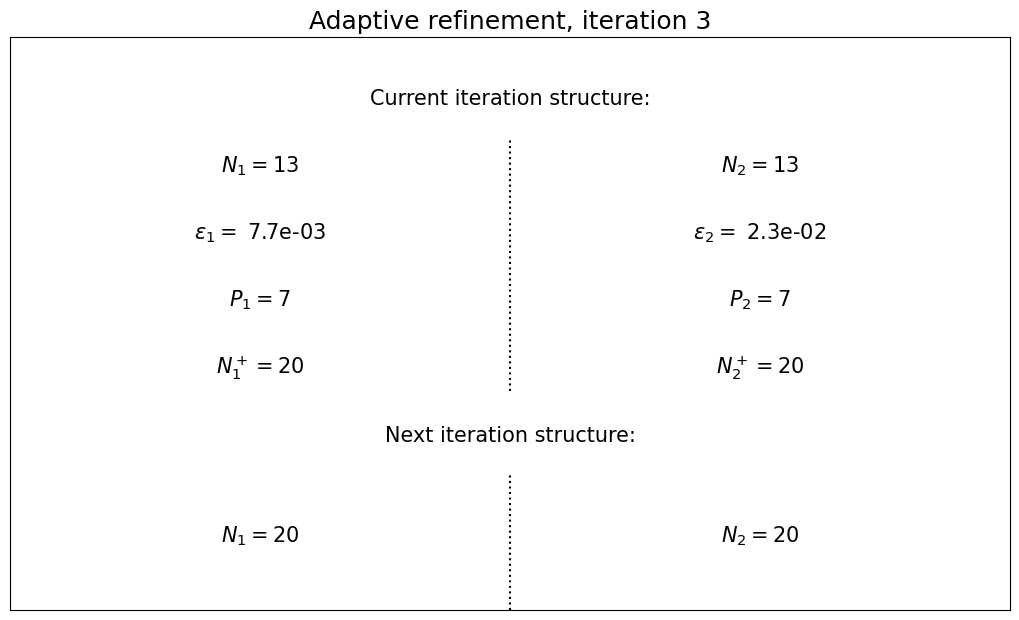

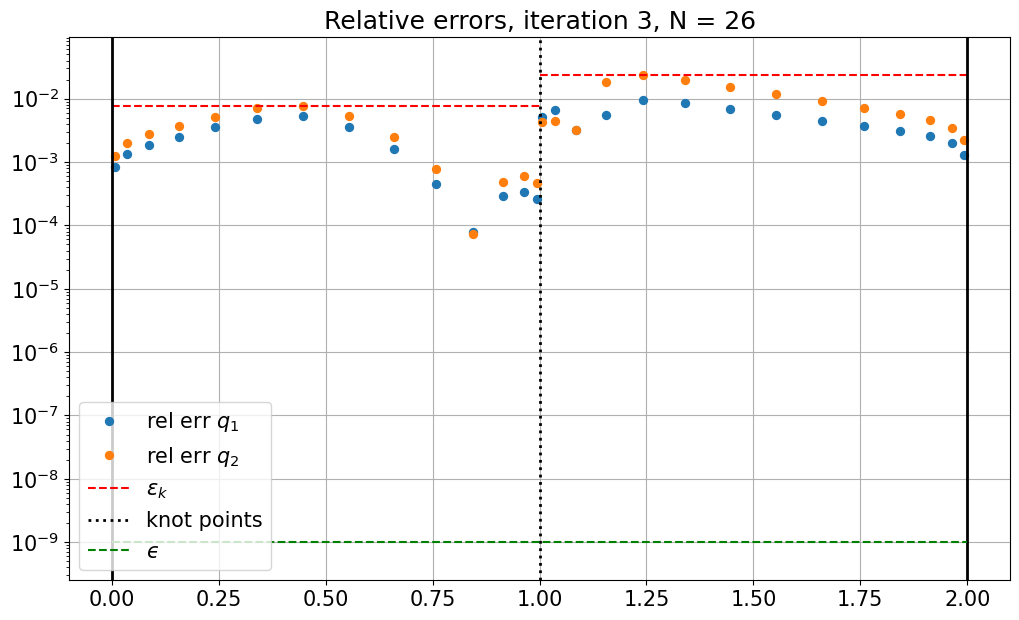

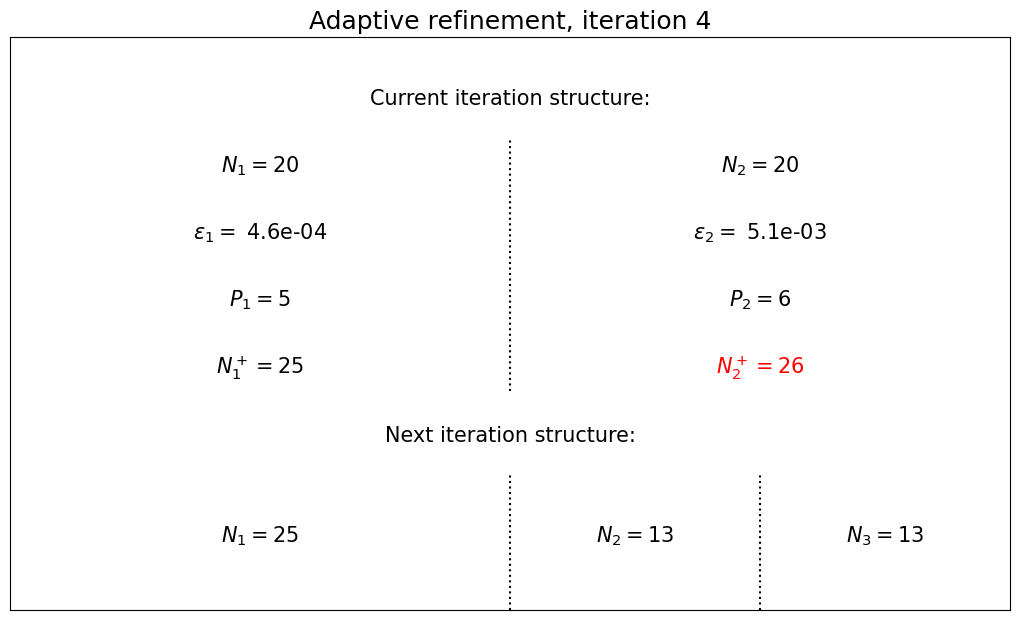

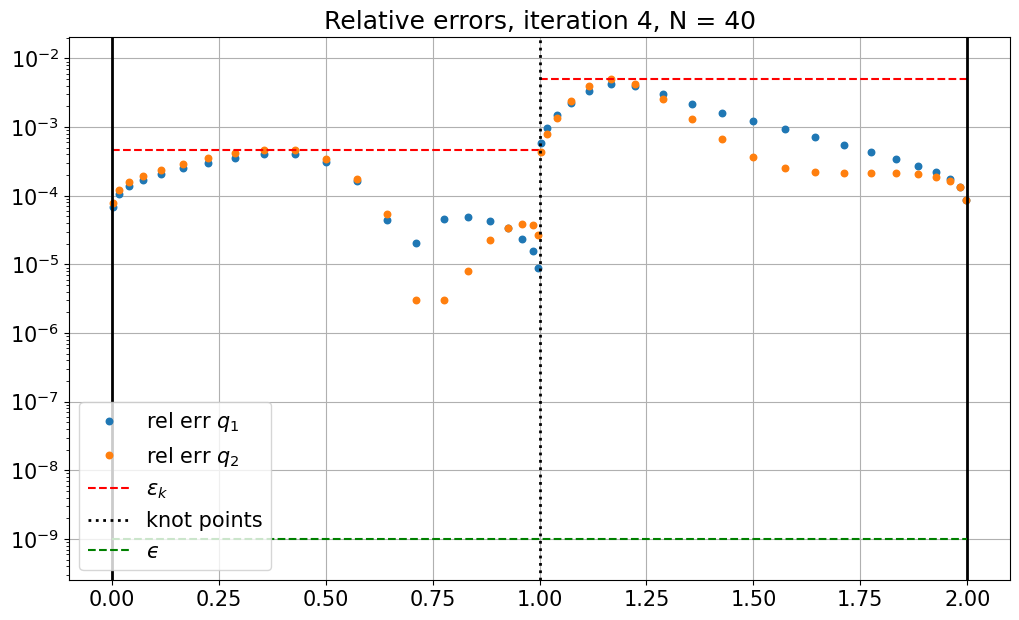

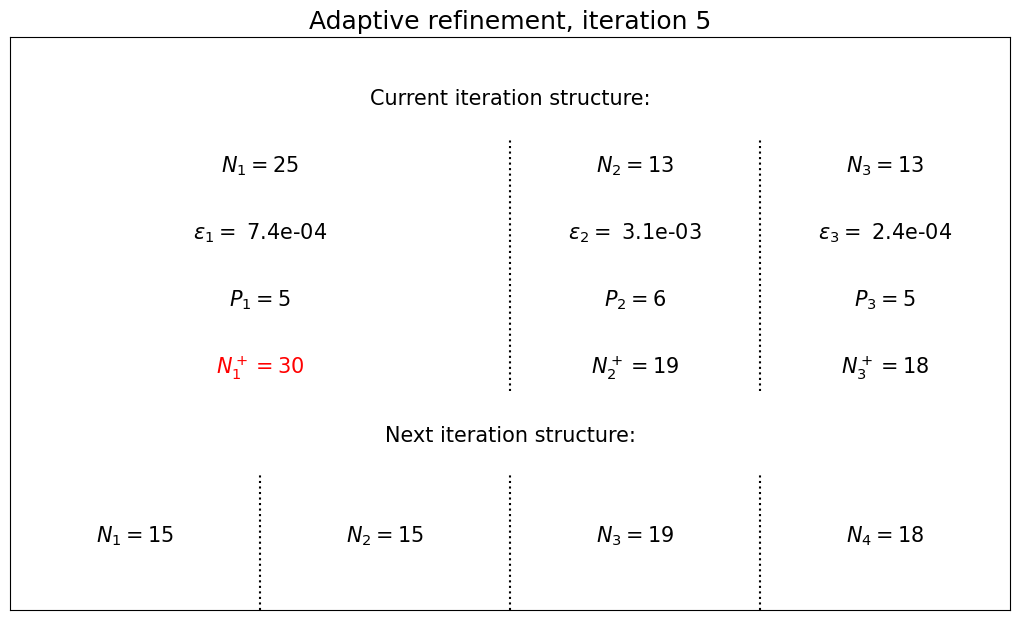

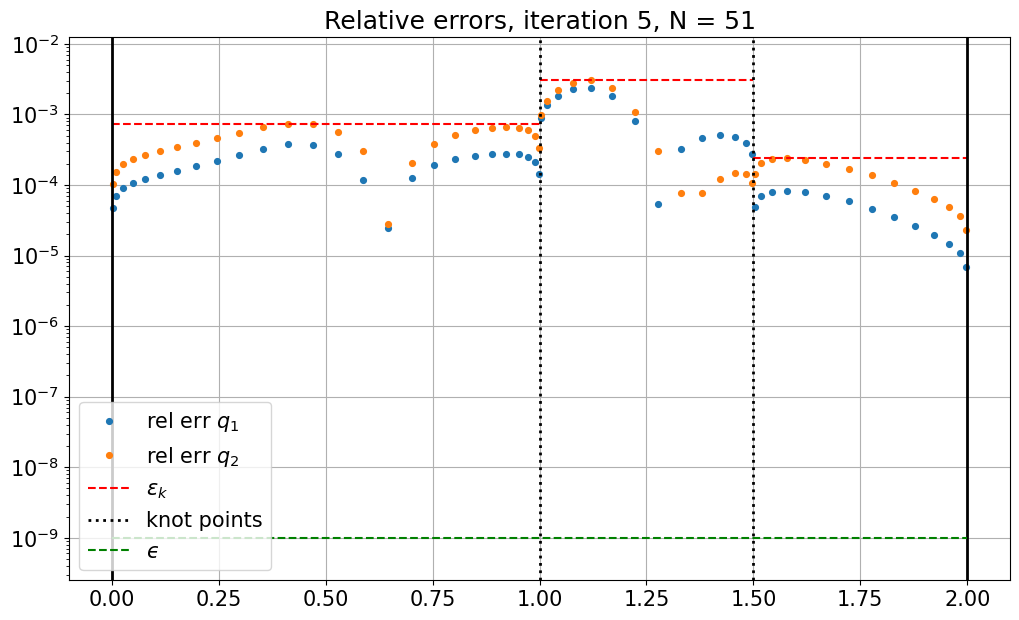

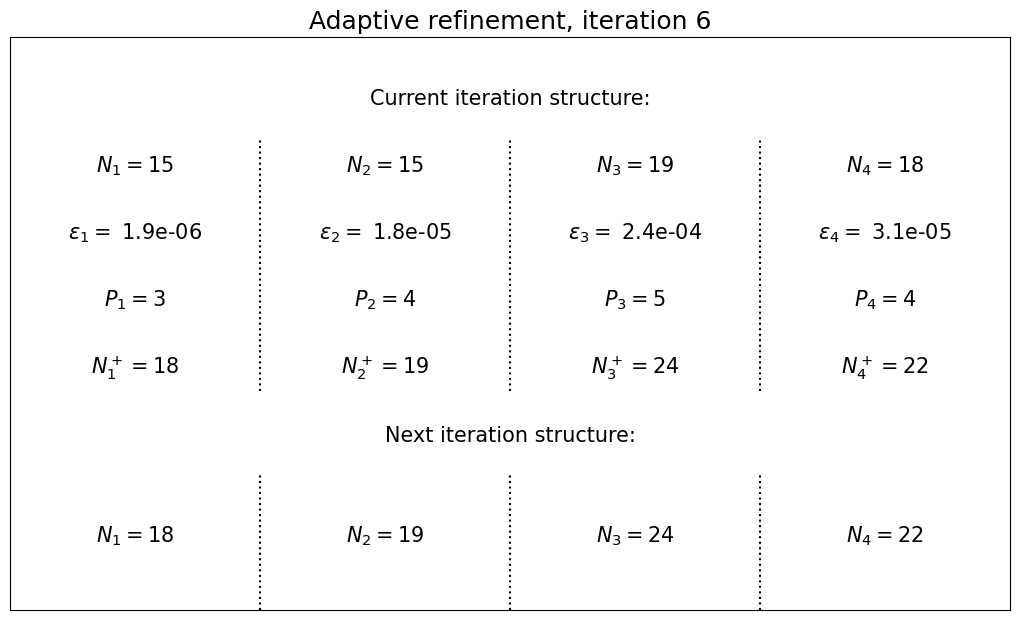

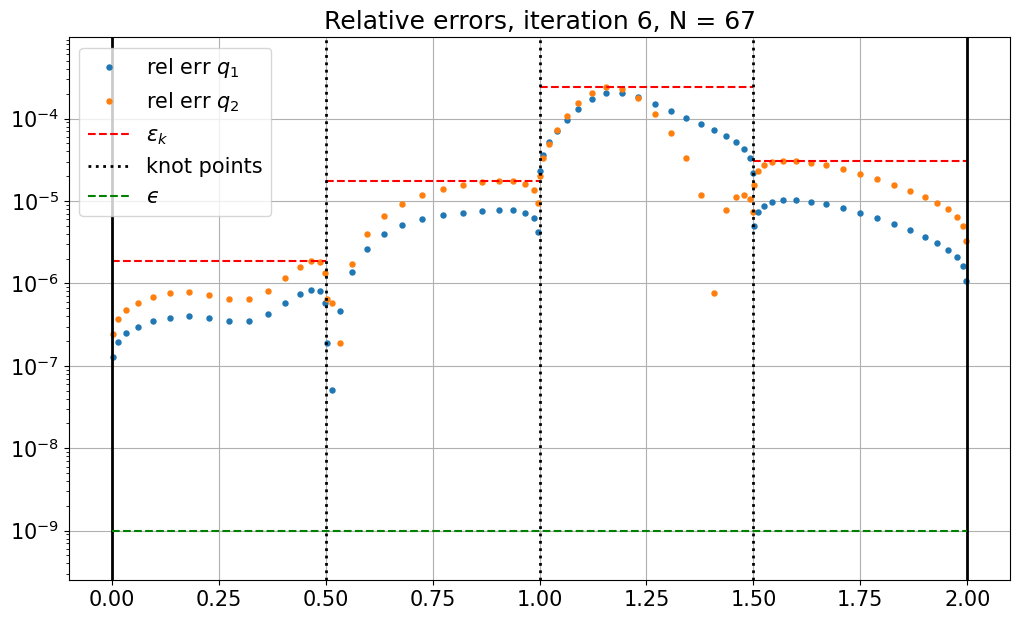

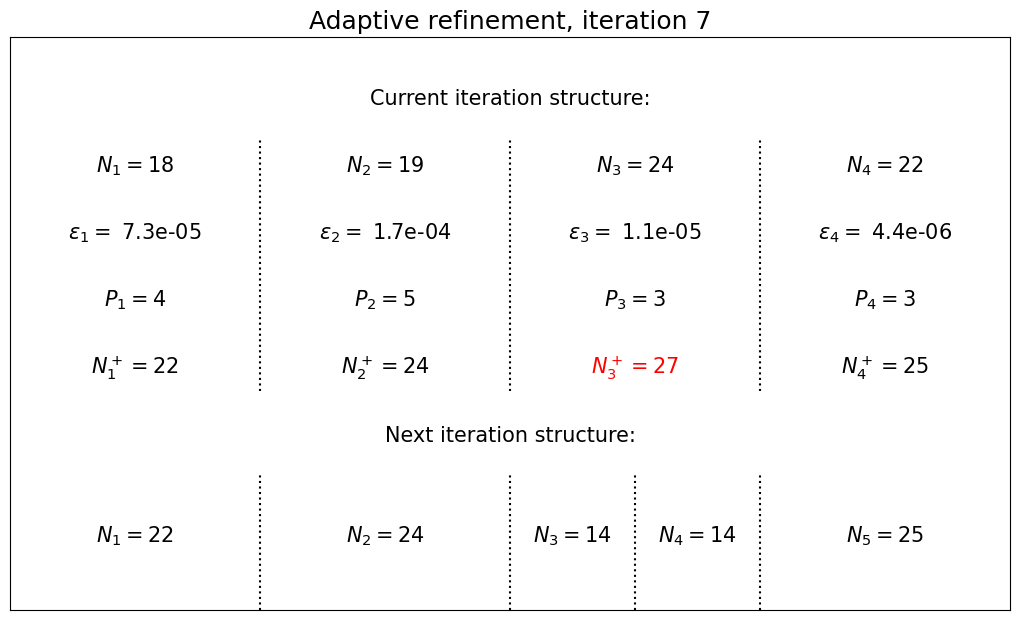

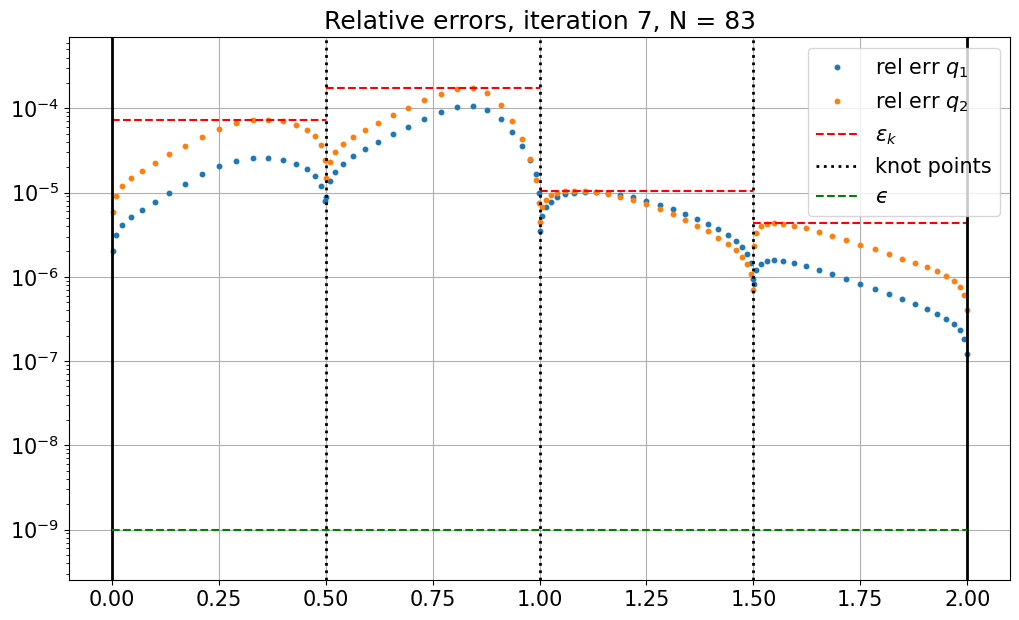

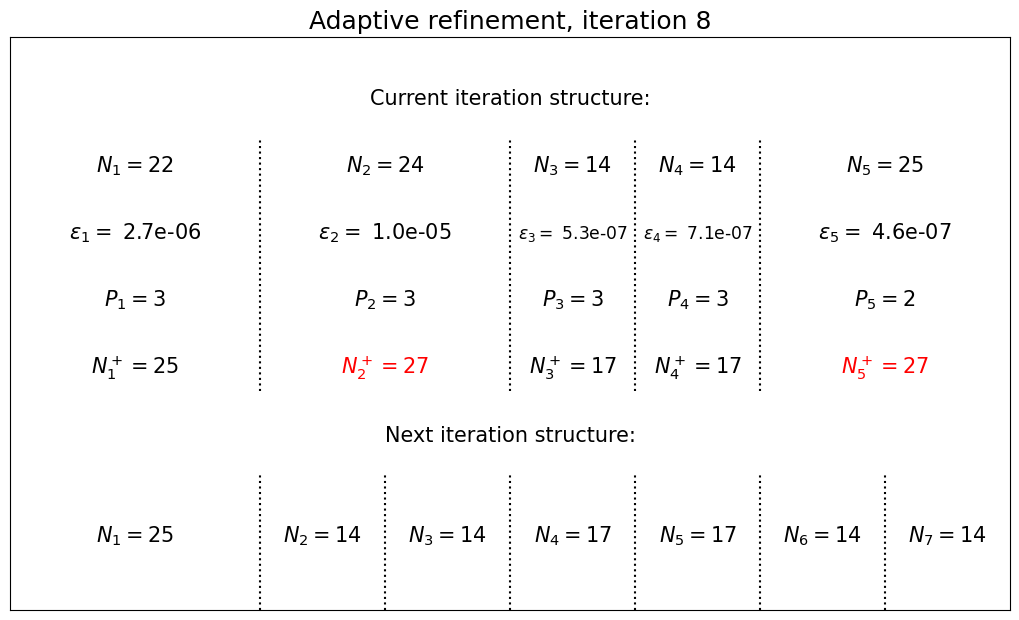

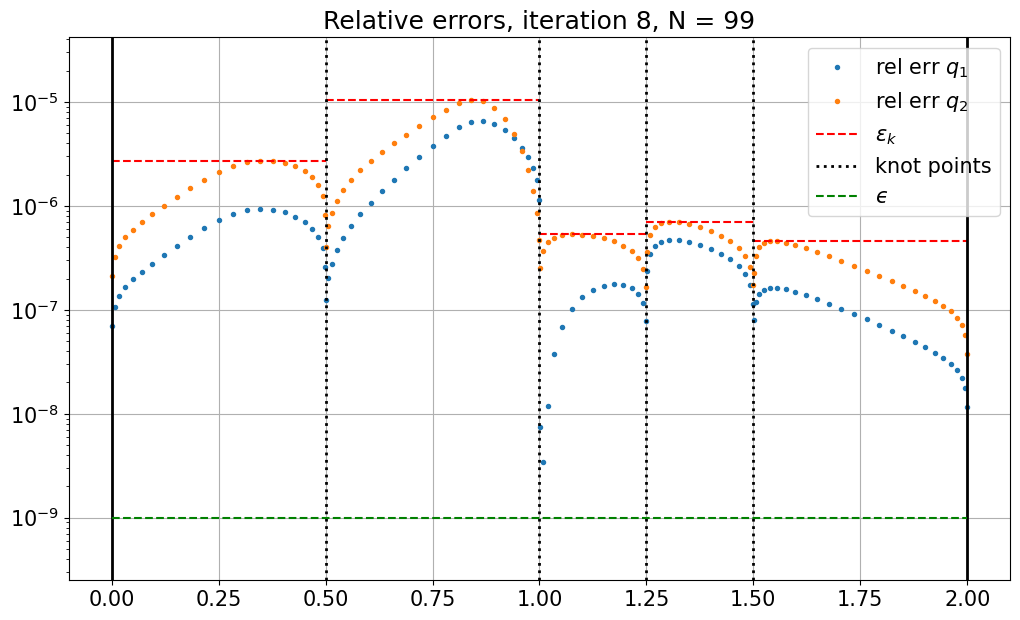

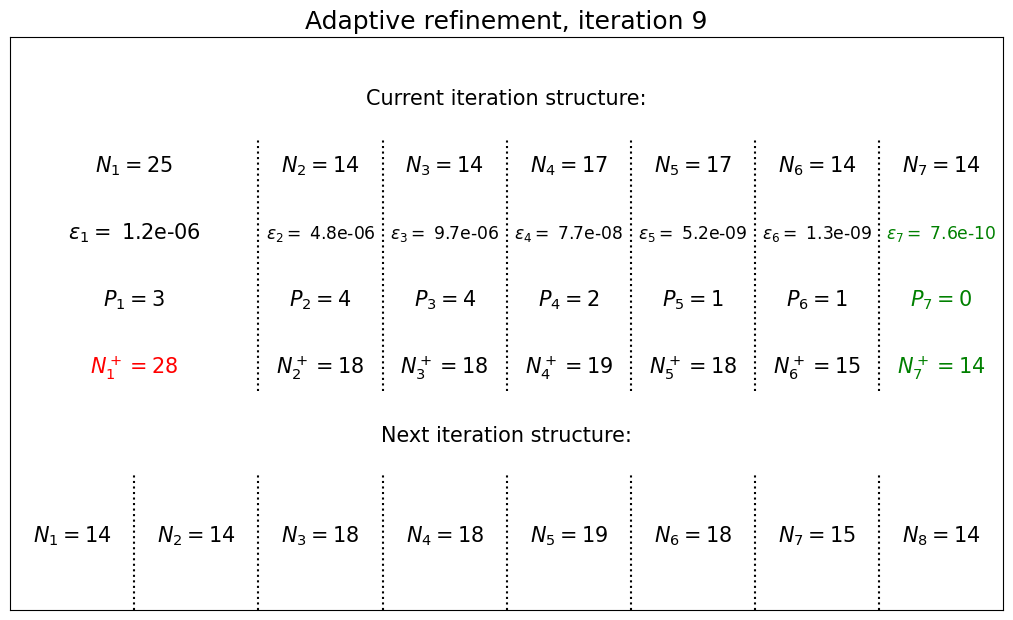

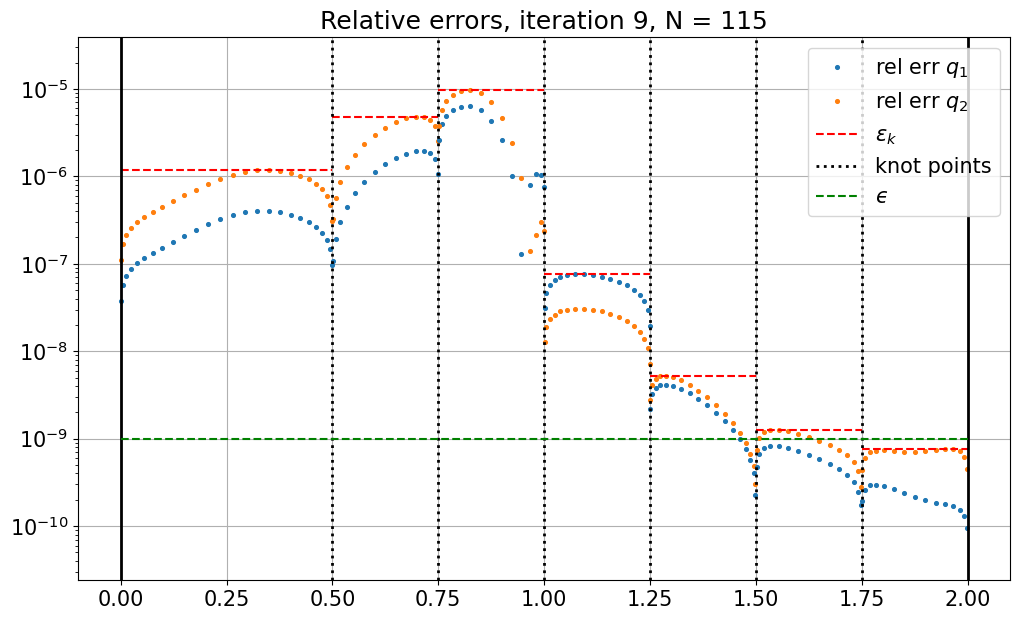

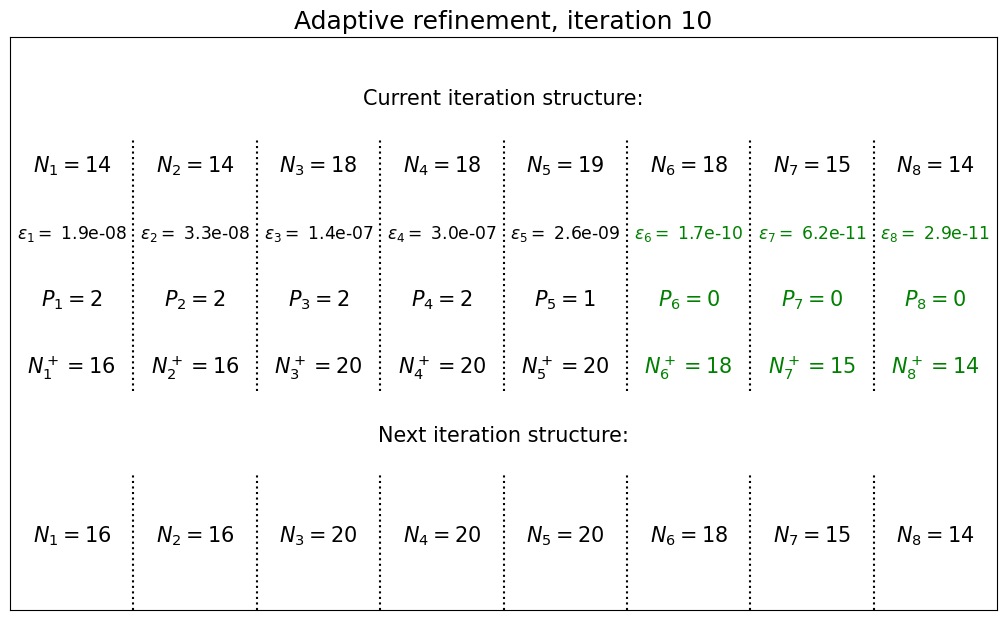

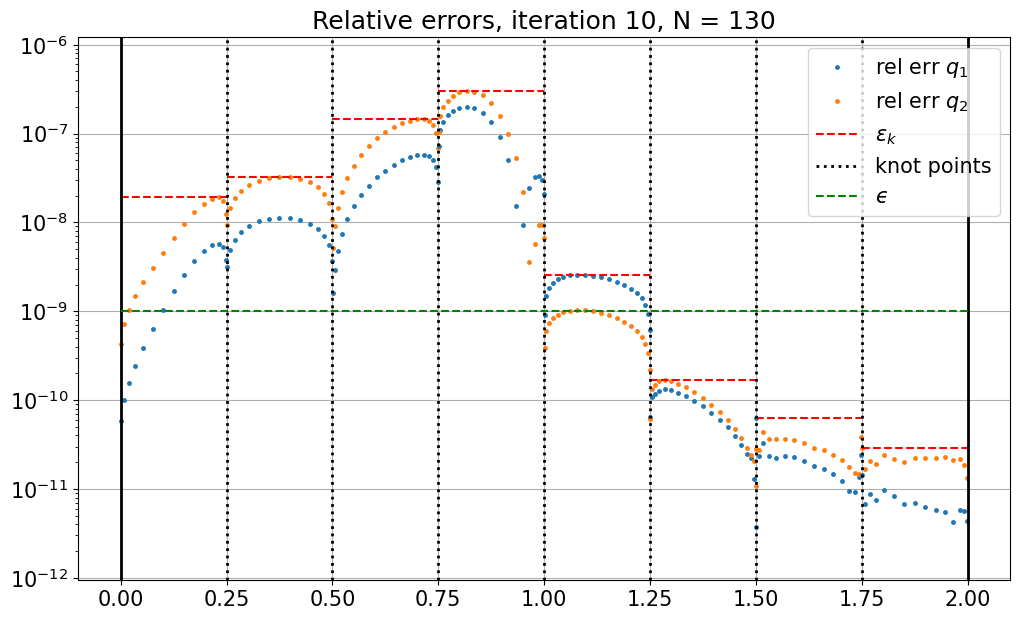

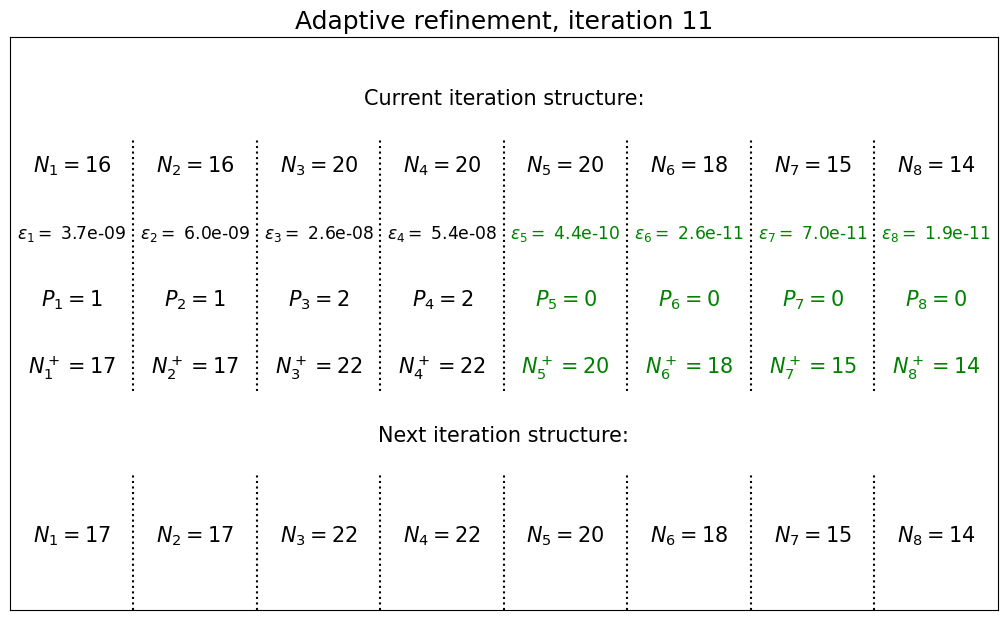

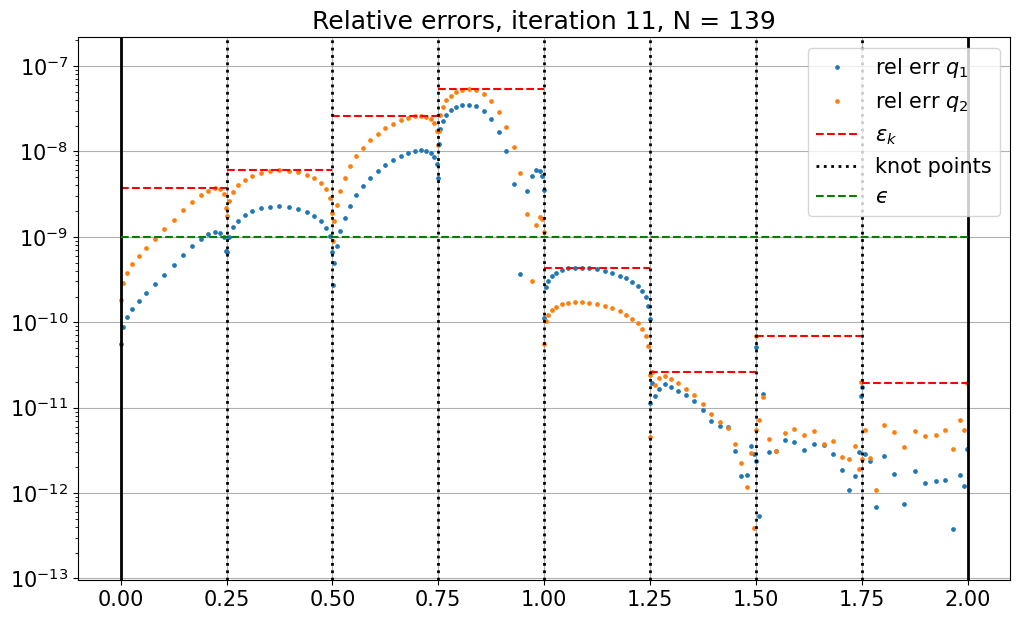

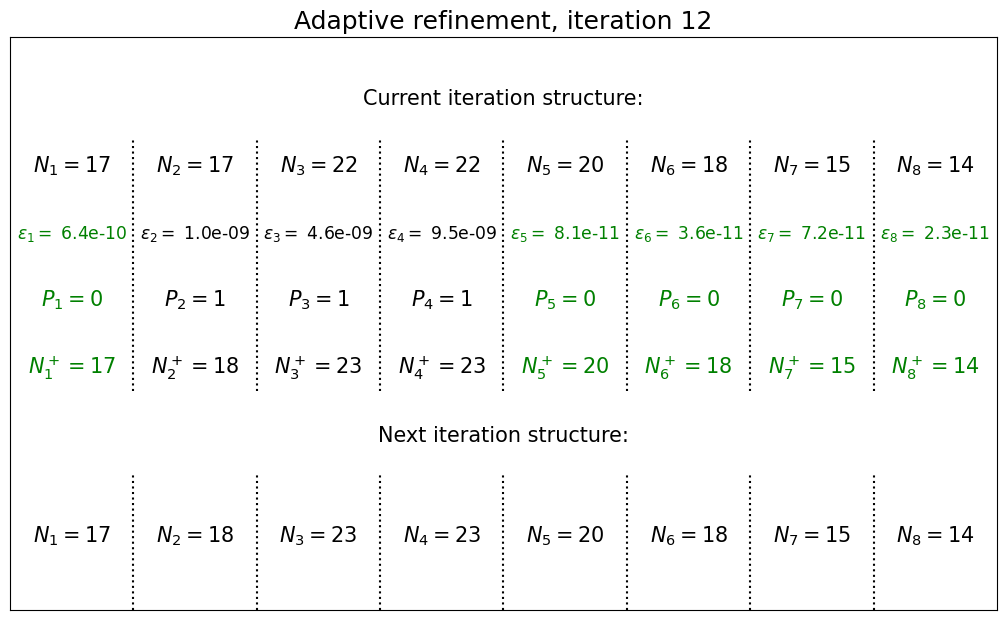

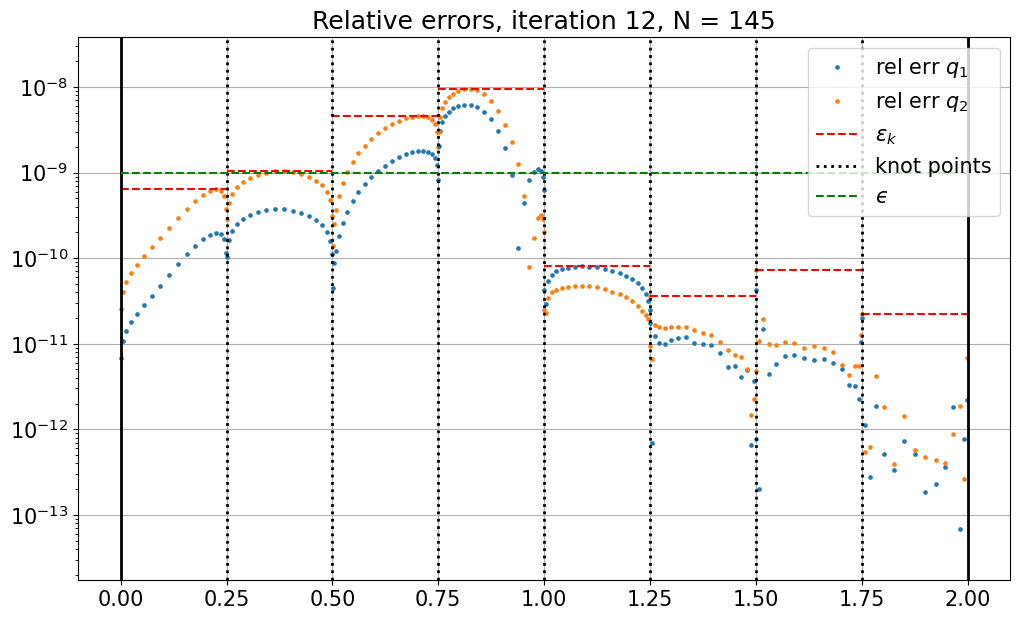

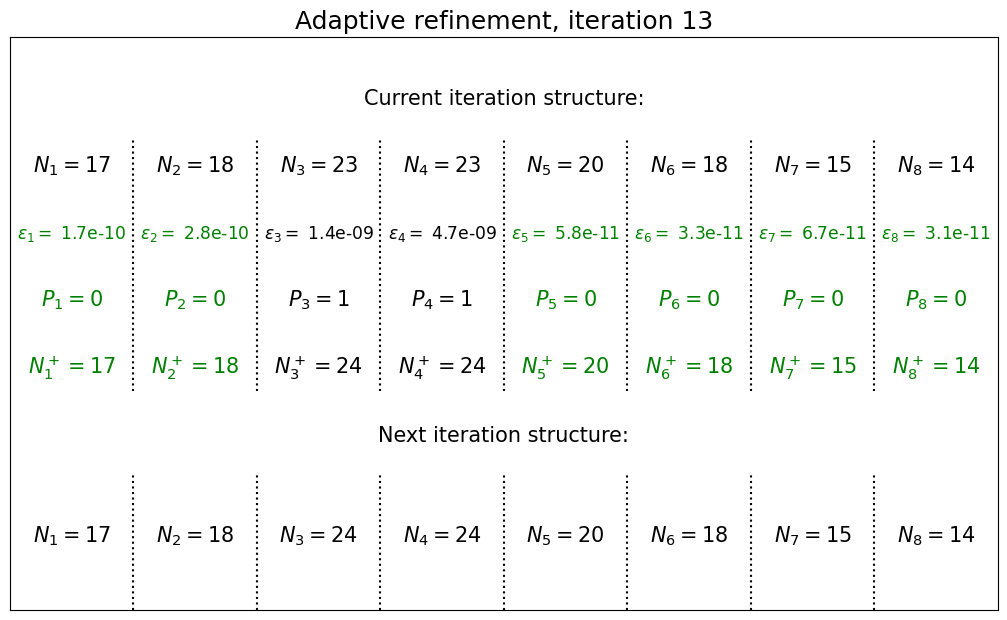

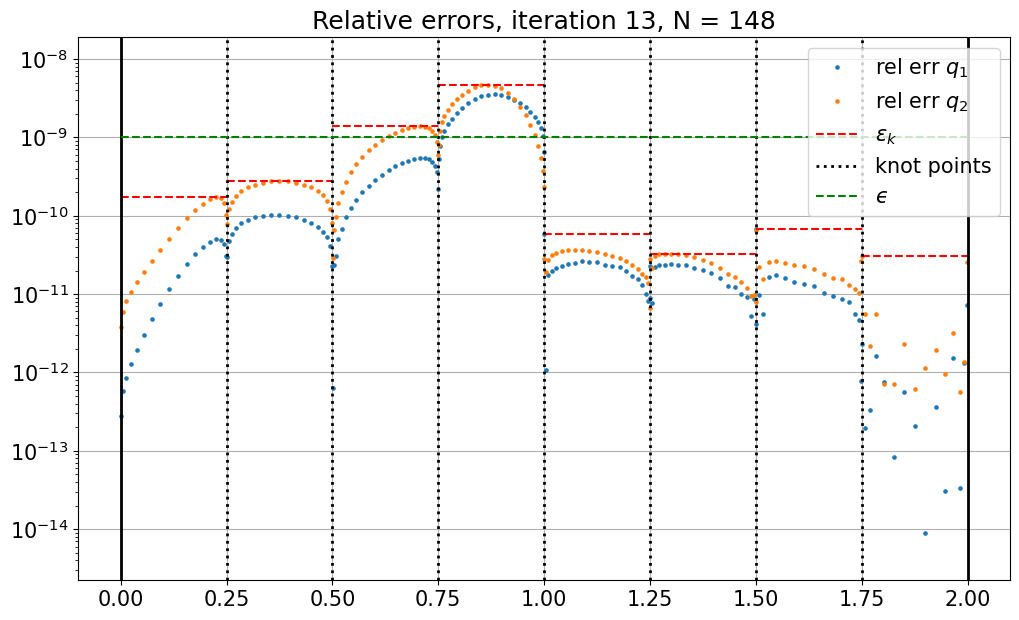

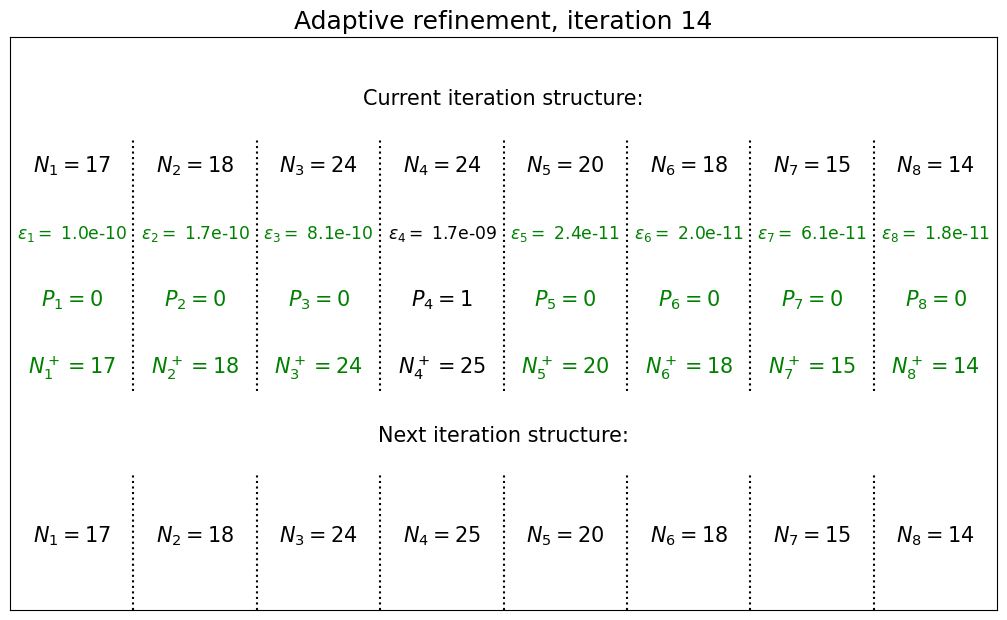

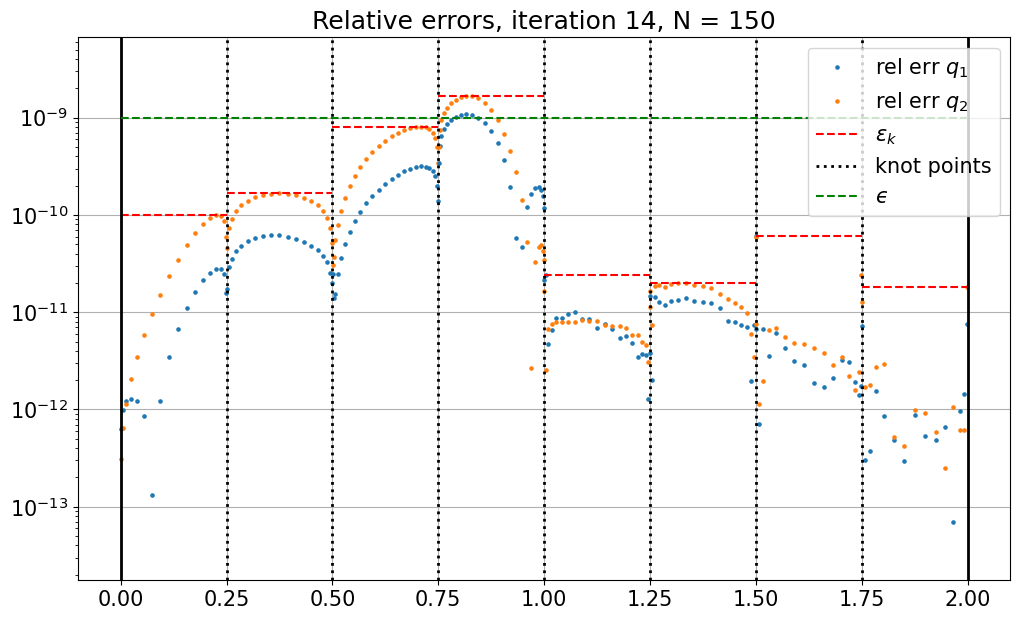

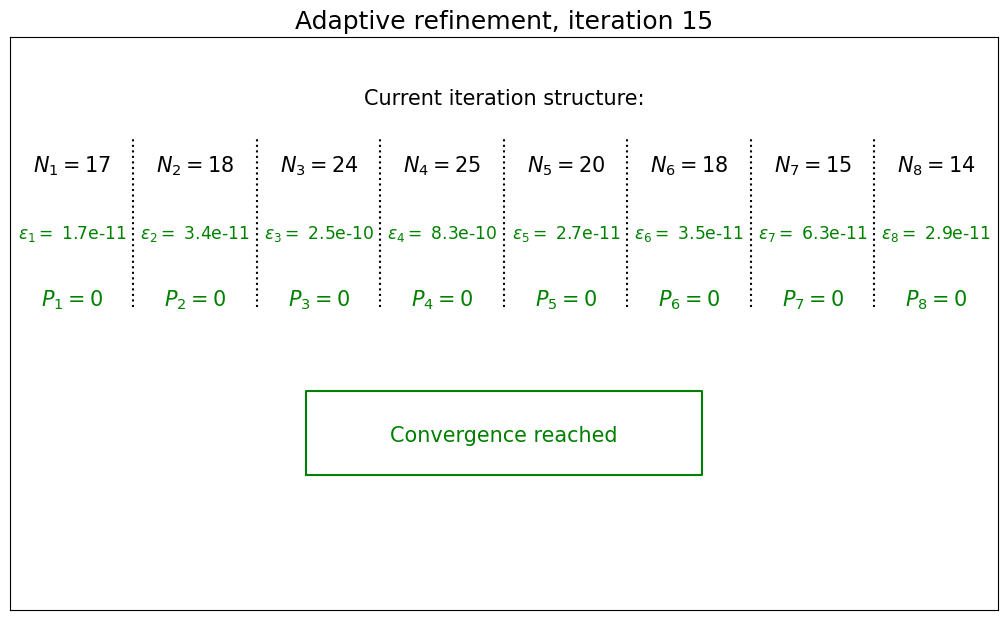

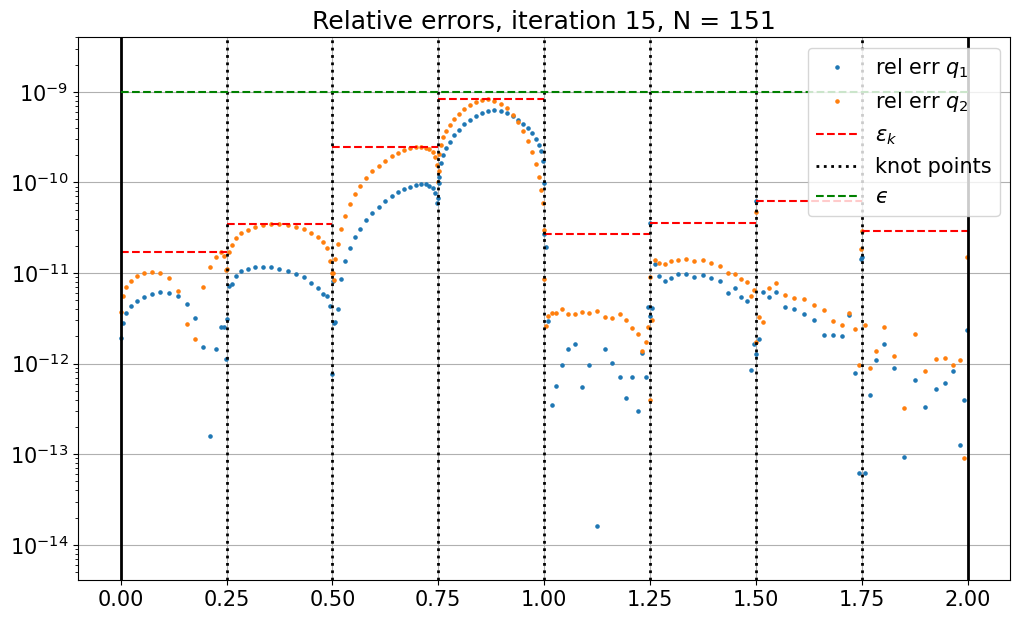

In [69]:
for _res in ph_run:
    plot_adp_ref_table(_res)
    plot_rel_err(_res)
    pass

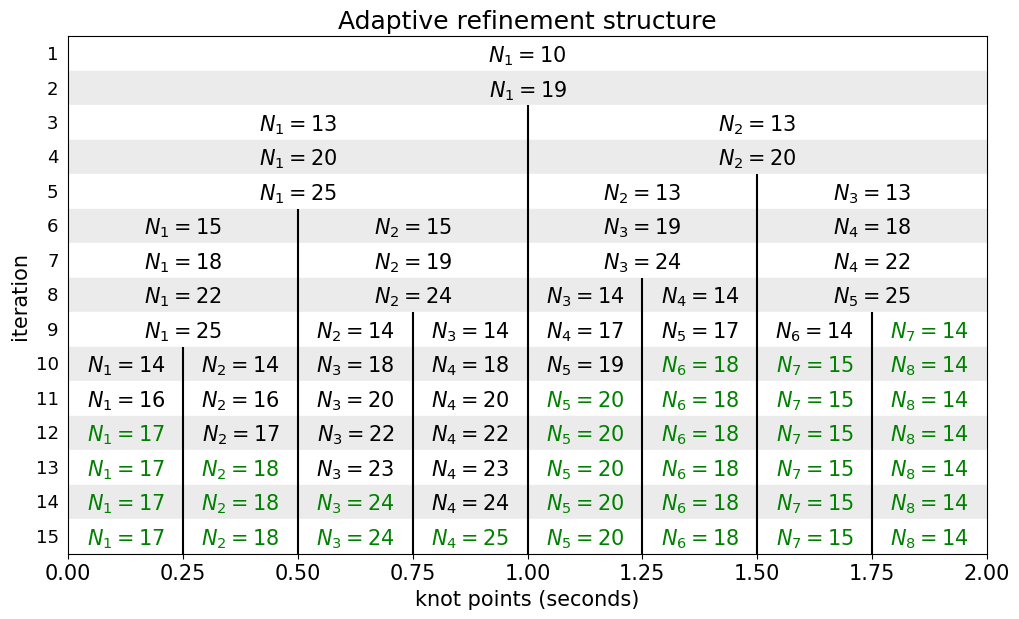

In [70]:
plt.figure(figsize=oct_fig_size)
_N = _res['n_coll_total']
plt.title(f'Adaptive refinement structure')
plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left = False,
        labelleft = True,
        labelbottom=True)

N_problems = len(ph_run)


plt.xlim(0,2)
plt.ylim(1.97-0.11*N_problems,1.97)
y_ticks = 1.92 - 0.11 * np.arange(N_problems)
y_labels = np.arange(N_problems)+1
plt.yticks(y_ticks, y_labels, fontsize = 13)
plt.ylabel('iteration')
plt.xlabel('knot points (seconds)')
color_back =[
    'w',
    '0.92',
]

for kk in range(N_problems):
    _res = ph_run[kk]
    add_p = _res['add_p']
    interv_centers = (_res['t_knot_ext'][:-1]+_res['t_knot_ext'][1:])/2
    point_n = _res['point_structure'] + add_p
    c_ii = kk%len(color_back)
    plt.fill_between(
        [0,2],
        [1.97-0.11*(kk+1), 1.97-0.11*(kk+1)],
        [1.97-0.11*(kk), 1.97-0.11*(kk)], 
        color = color_back[c_ii]
    )
    plt.vlines(
            _res['t_knot'],
            1.97-0.11*(kk+1),
            1.97-0.11*(kk),
            color = 'k',
            ls = '-',
        )
    for ii in range(_res['n_segments']):
        c_item = 'k' if add_p[ii] > 0 else 'g'
        
        h_text = _res['t_knot_ext'][ii+1] - _res['t_knot_ext'][ii]
        if h_text>0.2:
            txt_size = 15
            txt = f'$N_{ii+1}=$' + str(_res['point_structure'][ii])
        else:
            txt_size = 11
            txt = f'$N_{ii+1}$=' + str(_res['point_structure'][ii])
            
        plt.text(
            interv_centers[ii],
            2-0.11*(kk+1),
            txt,
            ha = 'center',
            c = c_item,
            size = txt_size
        )
plt.tight_layout(pad = 0.0)
if save:
    save_fig(
        problem_name = problem_name,
        graph_name = 'ph_results_table',
        schemes_printed = [scheme],
        save_format = save_fmt,
        N = '',
        q_counter = None,
        add=None
    )

In [71]:
_res_ph = analyze_ph_run(ph_run, F_nump)

In [72]:
save = True#False#
save_fmt = 'pdf'
fixed_y_scale = True#False#
fixed_x_scale = True#False#

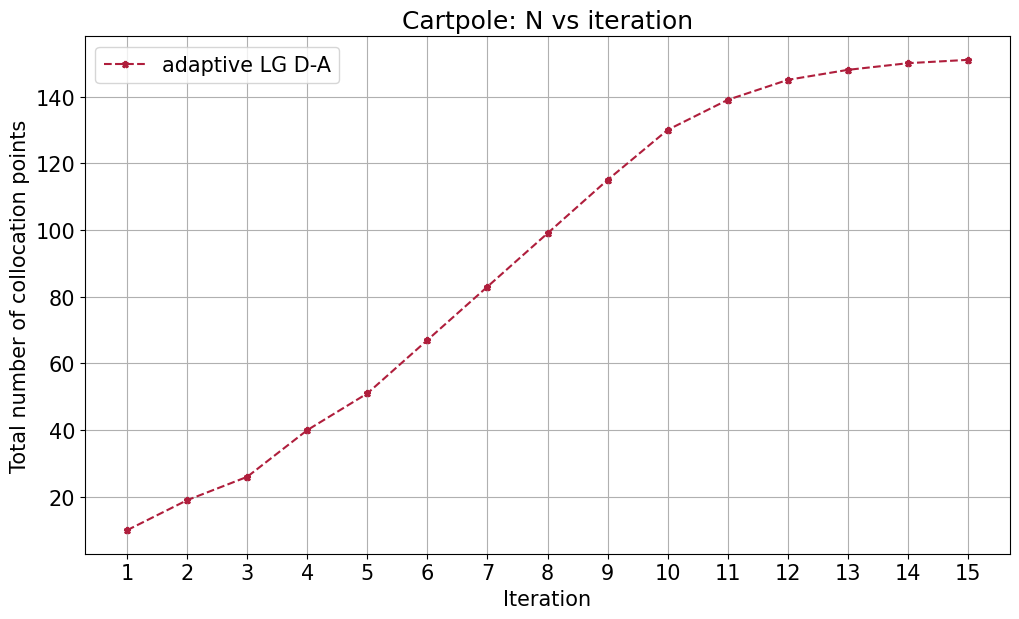

In [73]:
data_array = ['err_q_acum','err_v_acum','err_2_acum','cpudt']
data_key = data_array[2]
qq = 0
order_in_legend = False
markersize = 5
scale = 'log'
max_n_plot = 160
fixedticks = False

plt.figure(figsize=oct_fig_size)
plt.title(r'Cartpole: N vs iteration')#_{q_'+f'{qq+1}}}
scheme = 'ph_TD_LG'
plot_kw = scheme_kwargs(scheme, longlabel=False)
plot_kw['ls'] = ':'

if order_in_legend:
    plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
    
plot_kw['label'] = plot_kw['label'].replace('-M','-2')
plot_kw['ms'] = markersize
if 'TD' in scheme:
    plot_kw['marker'] = 'x'
    plot_kw['mew'] = '2'

if 'BU' in scheme:
    plot_kw['marker'] = '+'
    plot_kw['mew'] = '2'
if 'ph' in scheme:
    plot_kw['marker'] = '*'
    plot_kw['ls'] = '--'
N_arr = _res_ph['N_arr']

plt.plot(_res_ph['iterations'],
     N_arr,
     **plot_kw)

plt.xlabel('Iteration')
plt.grid()
plt.legend()#loc = 'lower left'
units = 'rad/s'
plt.xticks(_res_ph['iterations'])

plt.ylabel(f'Total number of collocation points')

plt.tight_layout(pad = 0.0)
if save:
    save_fig(
        problem_name = problem_name,
        graph_name = 'n_v_iter',
        schemes_printed = [scheme],
        save_format = save_fmt,
        N = None,
        q_counter = None,
    )

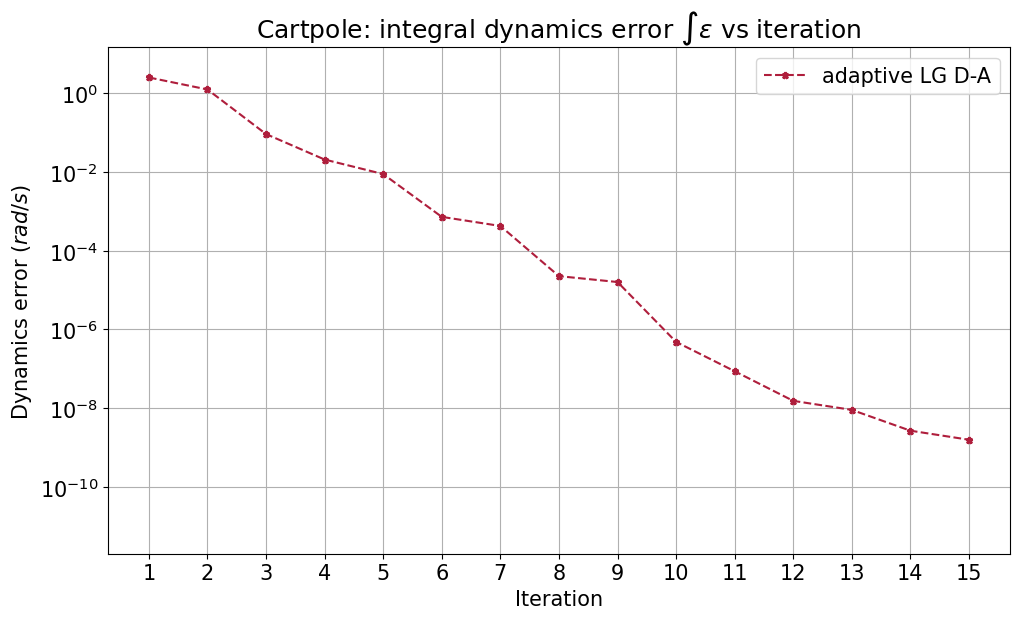

In [74]:
data_array = ['err_q_acum','err_v_acum','err_2_acum','cpudt']
data_key = data_array[2]
qq = 0
order_in_legend = False
markersize = 5
scale = 'log'
max_n_plot = 160
fixedticks = False

plt.figure(figsize=oct_fig_size)
plt.title(r'Cartpole: integral dynamics error $\int\varepsilon$ vs iteration')#_{q_'+f'{qq+1}}}
scheme = 'ph_TD_LG'
plot_kw = scheme_kwargs(scheme, longlabel=False)
plot_kw['ls'] = ':'

if order_in_legend:
    plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
    
plot_kw['label'] = plot_kw['label'].replace('-M','-2')
plot_kw['ms'] = markersize
if 'TD' in scheme:
    plot_kw['marker'] = 'x'
    plot_kw['mew'] = '2'

if 'BU' in scheme:
    plot_kw['marker'] = '+'
    plot_kw['mew'] = '2'
if 'ph' in scheme:
    plot_kw['marker'] = '*'
    plot_kw['ls'] = '--'
N_arr = _res_ph['N_arr']
if len(_res_ph[data_key].shape) == 1:
    plt.plot(_res_ph['iterations'],
     results[key][data_key],
     **plot_kw)
else:
    plt.plot(_res_ph['iterations'],
     _res_ph[data_key][:,qq],
     **plot_kw)

plt.xlabel('Iteration')
plt.grid()
plt.legend()#loc = 'lower left'
units = 'rad/s'

plt.yscale('log')
if fixed_y_scale:
    y_lims = [2e-12, 15]
    plt.ylim(y_lims)


plt.xticks(_res_ph['iterations'])

plt.ylabel(f'Dynamics error $({units})$')

plt.tight_layout(pad = 0.0)
if save:
    save_fig(
        problem_name = problem_name,
        graph_name = 'integ_dyn_error_iter',
        schemes_printed = [scheme],
        save_format = save_fmt,
        N = None,
        q_counter = None,
    )

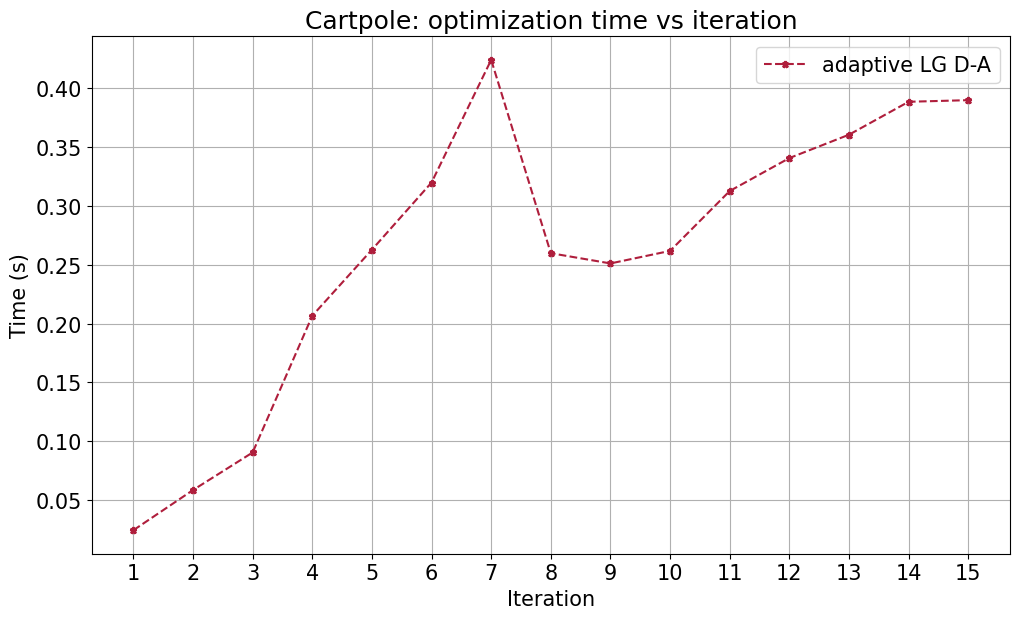

In [75]:
data_array = ['err_q_acum','err_v_acum','err_2_acum','cpudt']
data_key = data_array[2]
qq = 0
order_in_legend = False
markersize = 5
scale = 'log'
max_n_plot = 160
fixedticks = False

plt.figure(figsize=oct_fig_size)
plt.title(r'Cartpole: integral dynamics error $\int\varepsilon$ vs iteration')#_{q_'+f'{qq+1}}}
scheme = 'ph_TD_LG'
plot_kw = scheme_kwargs(scheme, longlabel=False)
plot_kw['ls'] = ':'

if order_in_legend:
    plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
    
plot_kw['label'] = plot_kw['label'].replace('-M','-2')
plot_kw['ms'] = markersize
if 'TD' in scheme:
    plot_kw['marker'] = 'x'
    plot_kw['mew'] = '2'

if 'BU' in scheme:
    plot_kw['marker'] = '+'
    plot_kw['mew'] = '2'
if 'ph' in scheme:
    plot_kw['marker'] = '*'
    plot_kw['ls'] = '--'
N_arr = _res_ph['N_arr']

plt.plot(_res_ph['iterations'],
     _res_ph[f'cpudt'],
     **plot_kw
    )
#if fixed_y_scale:
#    y_lims = [0.005, 30]
#    plt.ylim(y_lims)

plt.legend()
plt.title('Cartpole: optimization time vs iteration')
plt.ylabel('Time (s)')

plt.xlabel('Iteration')
plt.grid()
plt.legend()#loc = 'lower left'
units = 'rad/s'

#plt.yscale('log')



plt.xticks(_res_ph['iterations'])


plt.tight_layout(pad = 0.0)
if save:
    save_fig(
        problem_name = problem_name,
        graph_name = 'time_v_iter',
        schemes_printed = [scheme],
        save_format = save_fmt,
        N = None,
        q_counter = None,
    )

# Comparación sistemática de HP methods

In [ ]:
ph_complete_results = {}

In [ ]:
ph_complete_results = {}

for sch_mode in ['TD_', 'BU_', '',]:#'TD_', 'BU_', ''
    for sch in ['LG', 'LG_inv', 'LGL', 'LGR', 'LGR_inv']:
        if sch_mode != '' and sch == 'LG_inv':
            continue
        if sch_mode == '':
            order = 1
        else:
            order = 2
        scheme = f'ph_{sch_mode}{sch}'
        key = scheme + f'_{order}'
        print(scheme)
        ph_run = adaptive_refinement_system(
            problem = casadi_cartpole,
            F = F_nump,
            scheme = scheme,
            order = order,
            problem_kwargs = None,
            initial_t_knots = None,
            initial_point_structure = np.array([10]),
            min_p = 3,
            max_p = 40,
            epsilon = 1e-9,
            max_iter = 50,
            max_coll_points = 250,
        )
        ph_complete_results[key] = ph_run

In [ ]:
ph_results = {}
for ii, key in enumerate(ph_complete_results.keys()):
    print('Problem:', key, f' {ii+1} of {len(ph_complete_results.keys())} - ', time.strftime('%H:%M:%S ', time.localtime(time.time())))
    _res_ph = analyze_ph_run(ph_complete_results[key], F_nump)
    ph_results[key] = _res_ph
    scheme = key[:-2]
    ph_results[key]['scheme'] = scheme
    order = ph_complete_results[key][0]['solve_order']
    ph_results[key]['order'] = order

In [ ]:
ph_complete_results[key][0].keys()

In [ ]:

for ii, key in enumerate(ph_complete_results.keys()):
    print('Problem:', key)
    if 'TD' not in key and 'BU' not in key:
        pass
        #ph_results[key]['order'] = 1
    print('\torder: ', ph_results[key]['order'])

In [ ]:
ph_results.keys()

In [ ]:
n_interp = 1000
#t_interp = np.linspace(0,2,n_interp)
#tau_interp = np.linspace(-1,1,n_interp)

interpolations = interpolation(
    _res,
    problem_order = 2,
    scheme_order=2,
    x_interp=None,
    u_interp=None,
    n_interp=n_interp,
    #given_t_array=test_int_points
)
q_arr = interpolations['q']
v_arr = interpolations['v']
u_arr = interpolations['u']
a_arr = interpolations['a']
t_interp = interpolations['t']

In [ ]:
plt.figure(figsize=[14,8])
labels= ['q', 'theta']
for ii in range(2):
    plt.plot(_res['t'],_res['q'][:,ii], marker = 'o', ls = '', label = labels[ii])
    if 'parab' in _res['scheme']:
        plt.plot(_res['t_c'],_res['q_c'][:,ii], 'o', label = labels[ii] + '_c')
plt.plot(t_interp, q_arr)
plt.grid()
plt.legend()

In [ ]:
plt.figure(figsize=[14,8])
labels= ['q_dot', 'theta_dot']
v_res = _res['x'][:,2:]
for ii in range(2):
    plt.plot(_res['t'],v_res[:,ii], marker = 'o', ls = '', label = labels[ii])
    if 'parab' in _res['scheme']:
        plt.plot(_res['t_c'],_res['v_c'][:,ii], 'o', label = labels[ii] + '_c')
    plt.plot(t_interp, v_arr[:,ii])
plt.grid()
plt.legend()

In [ ]:
a_res = _res['x_d'][:,2:]
plt.figure(figsize=[14,8])
labels= ['q_dot_dot', 'theta_dot_dot']
for ii in range(2):
    plt.plot(_res['t'],a_res[:,ii], marker = 'o', ls = '', label = labels[ii])
    if 'parab' in _res['scheme']:
        a_res_c = _res['x_d_c'][:,2:]
        plt.plot(_res['t_c'],a_res_c[:,ii], 'o', label = labels[ii] + '_c')
plt.plot(t_interp, a_arr)
plt.plot(t_err, np.abs(dyn_err*4000), 'k:')
plt.grid()
plt.legend()

In [ ]:
plt.figure(figsize=[14,8])
plt.plot(_res['t_col'],_res['u'][:], marker = 'o', ls = '', label = 'u')
plt.plot(t_interp, u_arr)
if 'parab' in _res['scheme']:
    plt.plot(_res['t_c'],_res['u_c'][:], 'o', label = 'u_c')
plt.plot(t_err, np.abs(dyn_err*1000), 'k:')
plt.grid()
plt.legend()

In [ ]:
_res['cost']

# Cálculo integral error dinámico

In [ ]:
for sch_mode in ['TD_', 'BU_', '',]:#'TD_', 'BU_', ''
    for sch in ['LG', 'LG_inv', 'LGL', 'LGR', 'LGR_inv']:
        if sch_mode != '' and sch == 'LG_inv':
            continue
        scheme = f'{sch_mode}{sch}'
        print(scheme)
        _res = casadi_cartpole(
            scheme,
            N = n_col,
            t_knots_arr = t_knots_arr,
            point_structure = point_structure,
            ini_guess='lin',
            solve_repetitions=1,
            silent=True,
            verbose=False,
            order = order
        )
        print(_res['t'][:2],_res['t'][-2:])

In [ ]:
scheme = 'LGL'
n_col = 20
order = 1
t_knots_arr = [ ]
point_structure = [10,]
_res = casadi_cartpole(
    scheme,
    N = n_col,
    t_knots_arr = t_knots_arr,
    point_structure = point_structure,
    ini_guess='lin',
    solve_repetitions=1,
    silent=True,
    verbose=False,
    order = order
)

In [ ]:
_res['t']

In [ ]:
from chords.util import leggauss

In [ ]:
g_p, g_w = leggauss(5)

In [ ]:
tau_to_t_points(g_p, 0, 10)

In [ ]:
def calc_err_dyn_gauss_int(res, F, N_gauss = 15):
    g_p, g_w = leggauss(N_gauss)
    t_arr = _res['t']
    n_interv = len(t_arr)-1
    h = t_arr[1:] - t_arr[:-1]
    scale = h/2
    points = []
    weights = []
    for ii_interv in range(n_interv):
        t0 = t_arr[ii_interv]
        t1 = t_arr[ii_interv+1]
        sc = scale[ii_interv]
        points.append(tau_to_t_points(g_p, t0, t1))
        weights.append(g_w * sc)
    points = np.concatenate(points)
    weights = np.concatenate(weights)
    return points, weights

In [ ]:
_pp, _ww = calc_err_dyn_gauss_int(_res, F_nump)

In [ ]:
%%timeit
_err = dynamic_errors(
    res = _res,
    F = F_nump,
    dynamics_error_mode='q',
    problem_order=2,
    scheme_order=2,
    x_interp=None,
    u_interp=None,
    n_interp=None,
    save_in_res=True,
    given_t_array=_pp,
)
dyn_err = _err['dyn_err_interp']
dyn_err

%%timeit
_err = dynamic_errors(
    res = _res,
    F = F_nump,
    dynamics_error_mode='q',
    problem_order=2,
    scheme_order=2,
    x_interp=None,
    u_interp=None,
    n_interp=10,
    save_in_res=True,
    #given_t_array=_pp,
)
dyn_err = _err['dyn_err_interp']
dyn_err

%%timeit
_err = dynamic_errors(
    res = _res,
    F = F_nump,
    dynamics_error_mode='q',
    problem_order=2,
    scheme_order=2,
    x_interp=None,
    u_interp=None,
    n_interp=100,
    save_in_res=True,
    #given_t_array=_pp,
)
dyn_err = _err['dyn_err_interp']
dyn_err

%%timeit
_err = dynamic_errors(
    res = _res,
    F = F_nump,
    dynamics_error_mode='q',
    problem_order=2,
    scheme_order=2,
    x_interp=None,
    u_interp=None,
    n_interp=1000,
    save_in_res=True,
    #given_t_array=_pp,
)
dyn_err = _err['dyn_err_interp']
dyn_err

In [ ]:
plt.figure(figsize=[14,8])
plt.plot(_pp,dyn_err)
plt.grid()
plt.ylim([-3,3])
plt.plot(_res['t'],np.zeros_like(_res['t']), 'ok')

In [ ]:
n_interp = 1000
#t_interp = np.linspace(0,2,n_interp)
#tau_interp = np.linspace(-1,1,n_interp)

interpolations = interpolation(
    _res,
    problem_order = 2,
    scheme_order=2,
    x_interp=None,
    u_interp=None,
    n_interp=n_interp,
    #given_t_array=test_int_points
)
q_arr = interpolations['q']
v_arr = interpolations['v']
u_arr = interpolations['u']
a_arr = interpolations['a']
t_interp = interpolations['t']

In [ ]:
plt.figure(figsize=[14,8])
labels= ['q', 'theta']
for ii in range(2):
    plt.plot(_res['t'],_res['q'][:,ii], marker = 'o', ls = '', label = labels[ii])
    if 'parab' in _res['scheme']:
        plt.plot(_res['t_c'],_res['q_c'][:,ii], 'o', label = labels[ii] + '_c')
plt.plot(t_interp, q_arr)
plt.grid()
plt.legend()

In [ ]:
_res['t']

scheme = 'hs_mod_parab'
N = 25
xx, uu, uu_c, cpudt, _, cost = casadi_cartpole(N, scheme, 'lin', 1)

xx_interp, uu_interp = interpolated_array(
    X = xx,
    U = uu,
    F = F_nump,
    h = 2/N,
    t_array = np.linspace(0, 2, 2000),
    params = params,
    scheme = "hs_parab",
    u_scheme = 'parab',
    scheme_params = {'u_c' : uu_c}
)
plt.figure(figsize=[16,8])
plt.plot(np.linspace(0,2,N+1),uu[:], 'o',label = '$u_k$ points')
plt.plot(np.linspace(0,2,2*N+1)[1::2],uu_c, 'o',label = '$u_c$ points')
plt.plot(np.linspace(0,2,2000),uu_interp, label = 'interpolation')
plt.grid()
plt.legend()
plt.title('Cart-pole U(t) for 2nd order Hermite Simpson with N = 25')
labels = ['q1','q2','v1','v2']
for ii in range(4):
    plt.figure(figsize=[16,10])
    plt.plot(np.linspace(0,2,N+1),xx[:,ii], 'o',label = f'${labels[ii]}_k$ points')
    plt.plot(np.linspace(0,2,2000),xx_interp[:,ii], label = 'interpolation')
    plt.grid()
    plt.legend()
    plt.title(f'Cart-pole {labels[ii]}(t) for 2nd order Hermite Simpson with N = 25')

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 15})
oct_fig_size = [10,6]

def sch_to_lab(sch):
    label_dict = {
        'hs': 'HS-1-Toputto',
        'hs_mod': 'HS-2-Toputto',
        'hs_parab': 'HS-1',
        'hs_mod_parab': 'HS-2',
        'trapz':'TZ-1',
        'trapz_mod':'TZ-2'
    }
    return label_dict[sch]

def sch_to_long_label(sch):
    titles = ['Hermite Simpson',
          '2nd order Hermite Simpson',
          'Trapezoidal',
          '2nd order Trapezoidal',
          'Hermite Simpson (Toputto)',
          '2nd order Hermite Simpson (Toputto)',]
    schemes = ['hs_parab', 'hs_mod_parab','trapz', 'trapz_mod', 'hs', 'hs_mod']
    lname_dict = {}
    for ii in range(6):
        lname_dict[schemes[ii]] = titles[ii]
    return lname_dict[sch]
        

def sch_to_color(sch):
    color_dict = {}
    for ii, sc_name in enumerate(['hs_parab', 'trapz_mod', 'trapz', 'hs_mod_parab','hs', 'hs_mod']):
        color_dict[sc_name] = f'C{ii}'
    return color_dict[sch]

def scheme_kwargs(sch, longlabel=False):
    kwargs = {'marker' :'o', 'c':sch_to_color(sch)}
    if longlabel:
        kwargs['label'] = sch_to_long_label(sch)
    else:
        kwargs['label'] = sch_to_lab(sch)
    return kwargs

# Sistematic comparison of schemes for different values of N

Now let's solve the problem with different methods.

### Caution!

Executing the next cell may require some time!

In [ ]:
schemes = [
    #'LG2',
    'trapz',
    'hs_parab',
    'hsn_parab',
    'trapz_n',
    #'TD_LG',
    #'TD_CG',
    'LG',
    'LGR',
    'LGL',
    #'CG',
    #'BU_LG',
    #'BU_LGR',
    #'BU_LGL',
    #'BU_CG',
    #'TD_LG',
    #'TD_LGR',
    #'TD_LGL',
    #'TD_CG',
] #If you defined a custom function, name your scheme here
initials = ['lin']
solve_repetitions = 2 #Increase this number to get more reliable values of execution times
N_arr_base = [
    5, 7, 10, 12, 15, 20, 25, 30, 35, 40, 45, 50,
    55, 60, 70, 80, 90, 100,
    125, 150, 175, 200,
    225, 250, 
    #260, 275, 280, 300,]# 325, 350, 375, 400,]# 425, 450, 475, 500, 525, 550, 575, 600
]# You can increase the numbers here, but it will take more time
add_N_arr = [
    300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1250, 1500,
]
add_N_tz = [
    1750, 2000, 2500, 3000
]
#N_arr = [50, 60,]


recalculate = False#True#


# -----------------------

if recalculate:
    results = {}

for scheme in schemes:
        for order in range(1,3):
            if scheme == 'LG2' and order != 2:
                continue
            if scheme in ['LG', 'LGL', 'LGR', 'CG', 'CGL', 'CGR','hs_parab','trapz',] and order != 1:
                continue
            key = scheme + f'_{order}'
            
            if 'hs' in scheme:
                N_arr = N_arr_base + add_N_arr
            elif  'trapz' in scheme:
                N_arr = N_arr_base + add_N_arr + add_N_tz
                
            else:
                N_arr = N_arr_base
                
            if recalculate:
                results[key] = {'N_arr':N_arr}
                results[key]['scheme'] = scheme
                results[key]['order'] = order
            else:
                for element in N_arr:
                    if element not in results[key]['N_arr']:
                        results[key]['N_arr'].append(element)
                results[key]['N_arr'].sort()
            
ii = 0
for scheme in schemes:
    for order in range(1,3):
        if scheme == 'LG2' and order != 2:
            continue
        if scheme in ['LG', 'LGL', 'LGR', 'CG', 'CGL', 'CGR','hs_parab','trapz',] and order != 1:
            continue
        key = scheme + f'_{order}'
        print(f'Problem: {key}, {ii+1} of {len(results.keys())}')
        ii += 1
        N_arr = results[key]['N_arr']
        for N in N_arr:
            print ('\tN: ', N, time.strftime('%H:%M:%S ', time.localtime(time.time())))
            if recalculate or N not in results[key].keys():
                try:
                    results[key][N] = casadi_cartpole(
                    scheme,
                    N, 
                    'lin',
                    solve_repetitions=solve_repetitions,
                    order = order,
                    silent=True, 
                    verbose=False)
                except RuntimeError: 
                    results[key][N] = None
                    print('ATTEMPT FAILED!!')
                    results[key][N] = copy(casadi_cartpole(
                        scheme,
                        20, 
                        'lin',
                        solve_repetitions=solve_repetitions,
                        order = 2,
                        silent=True, 
                        verbose=False))
                    for item in results[key][N]:
                        try:
                            results[key][N][item] = results[key][N][item]*np.nan
                        except TypeError:
                            results[key][N][item] = np.nan
        


In [ ]:
for key in results.keys():
    if 'ph' in key:
        continue
    _c = []
    _cpudt = []
    _iters = []
    for N in results[key]['N_arr']:
        _c.append(results[key][N]['cost'])
        _cpudt.append(results[key][N]['cpudt'])
        _iters.append(results[key][N]['iteration'])
    results[key]['cost'] = np.array(_c)
    results[key]['cpudt'] = np.array(_cpudt)
    results[key]['iterations'] = np.array(_iters)

In [ ]:
plt.figure(figsize=oct_fig_size)
for key in results.keys():
    if 'ph' in key:
        continue
    scheme = results[key]['scheme']
    plot_kw = scheme_kwargs(scheme, longlabel=False)
    plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
    plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
    plt.plot(results[key]['N_arr'], results[key]['cost'][:], **plot_kw)
#plt.yscale('log')
plt.grid()
plt.legend()
plt.title('Final traj cost')

N = 60
scheme = 'BU_LG'
plt.figure(figsize=[14,8])

for ii in range(1,3):
    key = scheme + f'_{ii}'
    uu_pol, q_n_der_pols = chords.bu_pseudospectral.Polynomial_interpolations_BU(
        results[key][N]['x_d'],
        results[key][N]['x'][0,:],
        results[key][N]['u'],
        scheme,
        ii,
        0,
        2,
        N
    )
    

    plt.plot(results[key][N]['t_col'],results[key][N]['u'][:], 'o', label = 'u ' + key)
    plt.plot(t_interp_arr, uu_pol(t_interp_arr), 'grey',':')
plt.grid()
plt.legend()
points_ii = np.array([0, 12, 27, 33, 59])
uu_in = results[key][N]['u'][points_ii]
tt_in = results[key][N]['t_col'][points_ii]
plt.plot(tt_in,uu_in, '-', label = 'u interp')

## Dynamic Error

Now we can compute the dynamic errors for each case

In [ ]:
import chords
import importlib
importlib.reload(chords.td_pseudospectral)
importlib.reload(chords.util)
importlib.reload(chords.pseudospectral)
importlib.reload(chords.analysis)
importlib.reload(chords)
from chords.util import sch_to_color, sch_to_lab, scheme_kwargs

from chords.td_pseudospectral import dynamic_error_TD, interpolations_deriv_TD_pseudospectral

In [ ]:
results.keys()

In [ ]:
n_interp = 3000
for ii, key in enumerate(results.keys()):
    if 'ph' in key:
        continue
    scheme = results[key]['scheme'] 
    print('Problem:', key, f' {ii+1} of {len(results.keys())} - ', time.strftime('%H:%M:%S ', time.localtime(time.time())))
    N_arr = results[key]['N_arr']
    for N in N_arr:
        print(f'\tN = {N}')
        res = results[key][N]
        if res['scheme'] is np.nan:
            print('\t\tNaN in Scheme')
            nan_arr = np.zeros([n_interp, 2])*np.nan
            errors= {
                'compat_err_1_interp': nan_arr,
                'dyn_err_interp' : nan_arr,
            }
            res['error'] = errors
        else:
            if 'error' not in res.keys():
                errors = dynamic_errors(
                res,
                F_nump,
                dynamics_error_mode = 'q',
                problem_order=2,
                scheme_order=2,
                x_interp=None,
                u_interp=None,
                n_interp=n_interp,
            )
        dyn_err_q = errors['compat_err_1_interp']
        dyn_err_2 = errors['dyn_err_interp']
        t_arr = np.linspace(0,2, n_interp)
        tot_dyn_err_q = total_state_error(t_arr, dyn_err_q)
        tot_dyn_err_2 = total_state_error(t_arr, dyn_err_2)
        errors['err_q'] = tot_dyn_err_q
        errors['err_2'] = tot_dyn_err_2
            

def arr_mod(x):
    x_1 = np.sum(x*x, axis=1)
    return np.sqrt(x_1)
def arr_sum(x):
    return np.sum(np.abs(x), axis = 1)
def arr_max(x):
    return np.max(np.abs(x), axis = 1)

In [ ]:
for key in results.keys():
    if 'ph' in key:
        continue
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    err_q_acum = []
    err_2_acum = []
    cpudt = []
    for N in N_arr:
        errors = results[key][N]['error']
        err_q_acum.append(errors['err_q'])
        err_2_acum.append(errors['err_2'])
    results[key]['err_q_acum'] = np.array(err_q_acum, dtype = float)
    results[key]['err_2_acum'] = np.array(err_2_acum, dtype = float)
    

In [ ]:
results.update(ph_results)

In [ ]:
results.keys()

In [ ]:
from chords.util import plot_by_segments

for key in results.keys():
    scheme = results[key]['scheme']
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    for N in N_arr:
        print(f'\tN = {N}')
        _case = results[key][N]
        t_arr = np.linspace(0,
                        _case['t'][-1],
                        _case['dyn_err_2'].shape[0])
            
        _derivs = interpolations_deriv_TD_pseudospectral(
            _case['q_constr'],
            _case['x'],
            _case['x_d'],
            scheme,
            deriv_order = 1,
            t0 = 0,
            tf = _case['t'][-1],
            n_coll=_case['u'].shape[0],
            scheme_order = 2,
            x_interp="pol",
            n_interp=n_interp,
        )
        _accels = _derivs[:, 2:]
        
        #_case[f'sum_dyn_err_2_arr'] = arr_sum(_case['dyn_err_2']) # NOT VALID
        _case[f'sum_dyn_err_2_arr'] = None
        _case['a_arr'] = _accels
        _case['a_abs_mean_by_component'] = np.mean(np.abs(_accels), axis = 0)
        _case['a_abs_mean'] = np.mean(np.abs(_accels))
        #_case['a_abs_sum_arr'] = arr_sum(_accels) # NOT VALID
        _case['a_abs_sum_arr'] = None
        
        _case['rel_dyn_err_2_arr_by_instant_a_sum'] = arr_sum(_case['dyn_err_2']/_case['a_arr'])
        _case['rel_dyn_err_2_arr_by_total_mean_sum'] = None
        _case['rel_dyn_err_2_arr_by_mean_by_component_sum'] = arr_sum(_case['dyn_err_2']/_case['a_abs_mean_by_component'])
        _case['rel_dyn_err_2_arr_by_a_sum_arr_sum'] = None

def plot_by_segments(results, schemes, N, thing_to_plot, title, ylabel, component = 'all'):
    plt.figure(figsize=oct_fig_size)
    plot_coll_p = False
    for scheme in schemes:
        t_arr = np.linspace(0,
                        results[scheme][N]['t'][-1],
                        results[scheme][N][thing_to_plot].shape[0])
        interv_n = (N * t_arr)/results[scheme][N]['t'][-1]
        cut_p = 0
        for ll in range(1,N+1):
            jj = np.searchsorted(interv_n, ll)
            y_plot = results[scheme][N][thing_to_plot]
            if component != 'all':
                y_plot = y_plot[:, component]
            plt.plot(
                t_arr[cut_p:jj],
                y_plot[cut_p:jj],
                '-', c = sch_to_color(scheme),
                label = sch_to_lab(scheme) if cut_p == 0 else None)
            cut_p = jj
        if 'hs' in scheme:
            plot_coll_p = True
    plt.plot(results[scheme][N]['t'], np.zeros(N+1), 'ok', ms=5, label = 'knot & collocation points')
    if plot_coll_p:
        plt.plot(results[scheme][N]['t_c'], 
                     np.zeros(N), 'ow', ms=5, markeredgecolor='k',
                     label = 'collocation points')
    plt.legend()
    plt.grid()
    #plt.ylim([-0.01,y_max_list[ii]])
    plt.title(title)
    plt.xlabel('Time(s)')
    plt.ylabel(ylabel)
    plt.tight_layout(pad = 0.0)
    #plt.yscale('log')
    #plt.savefig(f'2d_order/5_link_HS_N{N}_second_order_dynamic_error.pdf', format='pdf')

sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme + '_lin'
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['err_q_int'][cut_p:jj,ii], '-', c = colors[2*hh+kk], label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        plt.title(r'First order dynamic error $\varepsilon^{[1]}_{q_'+f'{ii+1}}}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s' if ii == 0 else'rad/s'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        
        # If you are running the notebook locally and want to save the plots,
        # uncomment the next line
        #plt.savefig(f'Cartpole_First_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.eps', format='eps')

sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['err_2_int'][cut_p:jj,ii], '-', c = sch_to_color(key), label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        #plt.ylim([-0.00022, 0.00022])
        plt.title(r'Second order dynamic error $\varepsilon^{[2]}_{q_'+f'{ii+1}}}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s^2' if ii == 0 else'rad/s^2'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        # If you are running the notebook locally and want to save the plots,
        # uncomment the next line
        #plt.savefig(f'Cartpole_Second_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.eps', format='eps')

#schemes = ['trapz', 'trapz_mod']
ylabels = ['Error $(m/s)$','Error $(rad/s)$']
N = 20
save = False

for component in range(2):
    plt.figure(figsize=oct_fig_size)
    t_arr = np.linspace(
            0, results[key][N]["t"][-1], results[key][N]['error']['compat_err_1_interp'].shape[0]
        )
    for key in results.keys():
        scheme = results[key]['scheme']
        plot_kw = scheme_kwargs(scheme, longlabel=False)
        plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
        plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
        plot_kw['marker'] = ''
        plt.plot(t_arr, results[key][N]['error']['compat_err_1_interp'][:,component], **plot_kw)
    plt.plot(
        results[key][N]["t"],
        np.zeros(len(results[key][N]["t"])),
        "ok",
        ms=5,
        label="knot & collocation points",
    )
    plt.legend()
    plt.grid()
    plt.title(r'Cartpole: compatibility error $\varepsilon^{[1]}_{q_'+f'{component+1}}}(t)$, N = {N}')
    plt.xlabel("Time(s)")
    plt.ylabel(ylabels[component])
    plt.tight_layout(pad=0.0)
    if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'first_order_dyn_error',
            schemes_printed = schemes,
            save_format = 'pdf',
            N = N,
            q_counter = component,
        )
    

ylabels = ['Error $(m/s^2)$','Error $(rad/s^2)$']
N = 20
for component in range(2):
    plt.figure(figsize=oct_fig_size)
    t_arr = np.linspace(
            0, results[key][N]["t"][-1], results[key][N]['error']['dyn_err_interp'].shape[0]
        )
    for key in results.keys():
        scheme = results[key]['scheme']
        plot_kw = scheme_kwargs(scheme, longlabel=False)
        plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
        plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
        plot_kw['marker'] = ''
        plt.plot(t_arr, results[key][N]['error']["dyn_err_interp"][:,component], **plot_kw)
    plt.plot(
        results[key][N]["t"],
        np.zeros(len(results[key][N]["t"])),
        "ok",
        ms=5,
        label="knot & collocation points",
    )
    plt.legend()
    plt.grid()
    plt.title(r'Cartpole: dynamics error $\varepsilon_{q_'+f'{component+1}}}(t)$, N = {N}')
    plt.xlabel("Time(s)")
    plt.ylabel(ylabels[component])
    plt.tight_layout(pad=0.0)
    if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'second_order_dyn_error',
            schemes_printed = schemes,
            save_format = 'pdf',
            N = N,
            q_counter = component,
        )

data_array = ['err_q_acum','err_v_acum','err_2_acum','cpudt']
schemes = [
    #'LG2_2',
    #'hsn_parab_1',
    #'hsn_parab_2',
    'LG_1',
    #'LGR_1',
    #'LGL_1',
    #'CG_1',
    'BU_LG_1',
    'BU_LG_2',
    #'BU_LGR_1',
    #'BU_LGR_2',
    #'BU_LGL_1',
    #'BU_LGL_2'
    #'BU_CG_1',
    #'BU_CG_2',
    #'TD_LG_1',
    #'TD_LG_2',
    #'TD_CG_1',
    #'TD_CG_2',
]


#save = True
save = False

data_key = data_array[2]
for qq in range(2):
    plt.figure(figsize=oct_fig_size)
    plt.title(r'Cart-pole: integral dynamics error $\int\varepsilon_{q_'+f'{qq+1}}}$')
    for key in schemes: #results.keys():
        scheme = results[key]['scheme']
        #if "C" in scheme:
            #continue
            #pass
        plot_kw = scheme_kwargs(scheme, longlabel=False)
        plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
        plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
        N_arr = results[key]['N_arr']
        if len(results[key][data_key].shape) == 1:
            plt.plot(N_arr,
             results[key][data_key],
             **plot_kw)
        else:
            plt.plot(N_arr,
             results[key][data_key][:,qq],
             **plot_kw)
    plt.yscale('log')
    ticks = np.array(results[key]['N_arr'])
    #ticks = np.arange(0, results[key]['N_arr'][-1]+1, 25)
    plt.xticks(ticks, labels=ticks)
    plt.xlabel('Number of colocation points')
    plt.grid()
    plt.legend()#loc = 'lower left'
    units = 'm/s' if qq == 0 else'rad/s'
    plt.ylabel(f'Dynamics error $({units})$')
    plt.tight_layout(pad = 0.0)
    # If you are running the notebook locally and want to save the plots,
    # uncomment the next line
    if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'integ_dyn_error',
            schemes_printed = schemes,
            save_format = 'pdf',
            N = None,
            q_counter = qq,
        )


plt.figure(figsize=[10,6])
for key in schemes:
    scheme = results[key]['scheme']
    #if "C" not in scheme:
            #continue
            #pass
    plot_kw = scheme_kwargs(scheme, longlabel=False)
    plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
    plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
    plt.plot(results[key]['N_arr'],
             results[key][f'cpudt'],
             **plot_kw)
plt.grid()
plt.legend()
plt.title('Cart-pole: optimization time')
plt.xlabel('Number of collocation points')
plt.ylabel('Time (s)')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout(pad = 0.0)
ticks = np.array(results[key]['N_arr'])
#ticks = np.array(results[key]['N_arr'][:6]+results[key]['N_arr'][6:20:2]+[150,200,300,400])
#ticks = np.arange(0, results[key]['N_arr'][-1]+1, 25)
plt.xticks(ticks, labels=ticks)
_ = []
# If you are running the notebook locally and want to save the plots,
# uncomment the next line
if save:
    save_fig(
        problem_name = problem_name,
        graph_name = 'opt_time',
        schemes_printed = schemes,
        save_format = 'pdf',
        N = None,
        q_counter = None,
    )

In [ ]:
from chords.util import save_fig

In [ ]:
def plot_err_dyn(schemes, markersize = 10, n_q = 1, fixedticks = False,
                scale = 'log'):
    data_array = ['err_q_acum','err_v_acum','err_2_acum','cpudt']
    data_key = data_array[2]
    for qq in range(n_q):
        plt.figure(figsize=oct_fig_size)
        plt.title(r'Cartpole: integral dynamics error $\int\varepsilon$')#_{q_'+f'{qq+1}}}
        for key in schemes: #results.keys():#
            scheme = results[key]['scheme']
            plot_kw = scheme_kwargs(scheme, longlabel=False)
            plot_kw['ls'] = '-' if (
                results[key]['order'] == 1 or 'hs' in scheme or 'trapz' in scheme
            ) else ':'
            if order_in_legend:
                plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
            plot_kw['label'] = plot_kw['label'].replace('-M','-2')
            plot_kw['ms'] = markersize
            if 'TD' in scheme:
                plot_kw['marker'] = 'x'
                plot_kw['mew'] = '2'

            if 'BU' in scheme:
                plot_kw['marker'] = '+'
                plot_kw['mew'] = '2'
            if 'ph' in scheme:
                plot_kw['marker'] = '*'
                plot_kw['ls'] = '--'
            N_arr = results[key]['N_arr']
            if len(results[key][data_key].shape) == 1:
                plt.plot(N_arr,
                 results[key][data_key],
                 **plot_kw)
            else:
                plt.plot(N_arr,
                 results[key][data_key][:,qq],
                 **plot_kw)
        
        plt.xlabel('Number of colocation points')
        plt.grid()
        plt.legend()#loc = 'lower left'
        units = 'rad/s'

        plt.yscale('log')
        if fixed_y_scale:
            y_lims = [2e-12, 15]
            plt.ylim(y_lims)
        if scale == 'log':
            if fixed_x_scale:
                plt.xlim(1,max_n_plot+2)
            if fixedticks:
                ticks = np.array([
                    10, 20, 30, 40, 50,
                    60, 70, 80, 90, 100,
                    125, 150, 175, 200,
                    225, 250, 
                ])
        if scale == 'loglog':
            plt.xscale('log')
            if fixed_x_scale:
                plt.xlim(4.5,max_n_plot+10)
            if fixedticks:
                ticks = np.array([
                    5, 7, 10, 12, 15, 20, 25, 30, 35, 40, 50,
                    60, 70, 80, 100,
                    125, 150, 200, 250,
                ])
        
        if not fixedticks:
            ticks = np.array(results[key]['N_arr'])
        #ticks = np.arange(0, results[key]['N_arr'][-1]+1, 25)
        plt.xticks(ticks, labels=ticks)

        plt.ylabel(f'Dynamics error $({units})$')
        
        plt.tight_layout(pad = 0.0)
        if save:
            save_fig(
                problem_name = problem_name,
                graph_name = 'integ_dyn_error',
                schemes_printed = schemes,
                save_format = save_fmt,
                N = None,
                q_counter = None,
            )

In [ ]:
def plot_t_n(schemes, markersize = 10, fixedticks = False):
    plt.figure(figsize=[10,6])
    for key in schemes:#results.keys():
        scheme = results[key]['scheme']
        #if "C" not in scheme:
                #continue
                #pass
        plot_kw = scheme_kwargs(scheme, longlabel=False)
        plot_kw['ls'] = '-' if (
            results[key]['order'] == 1 or 'hs' in scheme or 'trapz' in scheme
        ) else ':'
        if order_in_legend:
            plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
        plot_kw['label'] = plot_kw['label'].replace('-M','-2')
        plot_kw['ms'] = markersize
        if 'TD' in scheme:
            plot_kw['marker'] = 'x'
            plot_kw['mew'] = '2'
        if 'BU' in scheme:
            plot_kw['marker'] = '+'
            plot_kw['mew'] = '2'
        if 'ph' in scheme:
            plot_kw['marker'] = '*'
            plot_kw['ls'] = '--'

        plt.plot(results[key]['N_arr'],
                 results[key][f'cpudt'],
                 **plot_kw
                )
    if fixed_y_scale:
        y_lims = [0.005, 30]
        plt.ylim(y_lims)
    if fixed_x_scale:
        plt.xlim(4.5,max_n_plot+10)
    plt.grid()
    plt.legend()
    plt.title('Cartpole: optimization time')
    plt.xlabel('Number of collocation points (log scale)')
    plt.ylabel('Time (s)')
    #plt.yscale('log')
    #plt.xscale('log')
    if fixedticks:
        ticks = np.array([
            5, 7, 10, 12, 15, 20, 25, 30, 35, 40, 50,
            60, 70, 80, 100,
            125, 150, 200, 250,
        ])
    else:
        ticks = np.array(results[key]['N_arr'])
    #ticks = np.array(results[key]['N_arr'][:6]+results[key]['N_arr'][6:20:2]+[150,200,300,400])
    #ticks = np.arange(5, results[key]['N_arr'][-1]+1, 5)
    plt.xticks(ticks, labels=ticks)
    _ = []
    
    plt.tight_layout(pad = 0.0)
    if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'opt_time',
            schemes_printed = schemes,
            save_format = save_fmt,
            N = None,
            q_counter = None,
        )

In [ ]:
markersize = 10
schemes = [
    #'LG2_2',
    'hs_parab_1',
    'trapz_1',
    #'hsn_parab_1',
    #'hsn_parab_2',
    #'trapz_n_1',
    #'trapz_n_2',
    'LG_1',
    'LGR_1',
    'LGL_1',
    #'CG_1',
    #'BU_LG_1',
    #'BU_LG_2',
    #'BU_LGR_1',
    #'BU_LGR_2',
    #'BU_LGL_1',
    #'BU_LGL_2',
    #'BU_CG_1',
    #'BU_CG_2',
    #'TD_LG_1',
    #'TD_LG_2',
    #'TD_LGR_1',
    #'TD_LGR_2',
    #'TD_LGL_1',
    #'TD_LGL_2',
    #'TD_CG_1',
    #'TD_CG_2',
    #'ph_TD_LG_2',
    #'ph_TD_LGL_2',
    #'ph_TD_LGR_2',
    #'ph_TD_LGR_inv_2',
    #'ph_BU_LG_2',
    #'ph_BU_LGL_2',
    #'ph_BU_LGR_2',
    #'ph_BU_LGR_inv_2',
    #'ph_LG_2',
    #'ph_LG_inv_2',
    #'ph_LGL_2',
    #'ph_LGR_2',
    #'ph_LGR_inv_2'
]

In [ ]:
import chords
import importlib
importlib.reload(chords.td_pseudospectral)
importlib.reload(chords.util)
importlib.reload(chords.pseudospectral)
importlib.reload(chords.analysis)
importlib.reload(chords)
from chords.util import sch_to_color, sch_to_lab, scheme_kwargs

In [ ]:
save = True#False#
save_fmt = 'pdf'
fixed_y_scale = True#False#
fixed_x_scale = True#False#


In [ ]:
max_n_plot = N_arr_base[-1]

In [ ]:
order_in_legend = False
plot_err_dyn(
    ['hs_parab_1','hsn_parab_2','trapz_1','trapz_n_2','LG_1','LGR_1','LGL_1',],
    #['LG_1','LGR_1','LGL_1','BU_LG_1','BU_LG_2','BU_LGR_1','BU_LGR_2','BU_LGL_1',
    #'BU_LGL_2','TD_LG_1','TD_LG_2','TD_LGR_1','TD_LGR_2','TD_LGL_1','TD_LGL_2',],
    markersize = 5,
    n_q=1,
    fixedticks=True,
    scale = 'loglog'
)
#plt.plot(_res_ph['N'], _res_ph['err_2'][:,0], marker = 'x', ls = '--')

plot_t_n(
    ['hs_parab_1','hsn_parab_2','trapz_1','trapz_n_2','LG_1','LGR_1','LGL_1',],
    #['LG_1','LGR_1','LGL_1','BU_LG_1','BU_LG_2','BU_LGR_1','BU_LGR_2','BU_LGL_1',
    #'BU_LGL_2','TD_LG_1','TD_LG_2','TD_LGR_1','TD_LGR_2','TD_LGL_1','TD_LGL_2',],
    markersize = 5,
    fixedticks=True)
#plt.plot(_res_ph['N'], _res_ph['cpudt'], marker = 'x', ls = '--')


In [ ]:
schemes_list = [
    ['LG_1','BU_LG_1','TD_LG_1',],
    ['BU_LG_1','BU_LG_2','TD_LG_1','TD_LG_2',],
    ['LG_1','BU_LG_1','BU_LG_2','TD_LG_1','TD_LG_2',],
    ['LGR_1','BU_LGR_1','TD_LGR_1',],
    ['BU_LGR_1','BU_LGR_2','TD_LGR_1','TD_LGR_2',],
    ['LGR_1','BU_LGR_1','BU_LGR_2','TD_LGR_1','TD_LGR_2',],
    ['LGL_1','BU_LGL_1','TD_LGL_1',],
    ['BU_LGL_1','BU_LGL_2','TD_LGL_1','TD_LGL_2',],
    ['LGL_1','BU_LGL_1','BU_LGL_2','TD_LGL_1','TD_LGL_2',],
    ['LG_1','LGR_1','LGL_1','BU_LG_1','BU_LG_2','BU_LGR_1','BU_LGR_2','BU_LGL_1',
    'BU_LGL_2','TD_LG_1','TD_LG_2','TD_LGR_1','TD_LGR_2','TD_LGL_1','TD_LGL_2',]
]

In [ ]:
schemes_list = [
    ['LG_1','LGR_1','LGL_1','BU_LG_1','BU_LG_2','BU_LGR_1','BU_LGR_2','BU_LGL_1',
    'BU_LGL_2','TD_LG_1','TD_LG_2','TD_LGR_1','TD_LGR_2','TD_LGL_1','TD_LGL_2',],
    
]

In [ ]:
schemes_list = [
    ['LG_1','LGR_1','LGL_1','ph_LG_2','ph_LGR_2','ph_LGL_2',],
    ['BU_LG_2','BU_LGR_2','BU_LGL_2','ph_BU_LG_2','ph_BU_LGR_2','ph_BU_LGL_2',],
    ['TD_LG_2','TD_LGR_2','TD_LGL_2','ph_TD_LG_2','ph_TD_LGR_2','ph_TD_LGL_2',],
    
]

In [ ]:
order_in_legend = False
for schemes in schemes_list:
    plot_err_dyn(
        schemes,
        markersize = 5,
        fixedticks=True
    )
    plot_t_n(
        schemes,
        markersize = 5,
        fixedticks=True
    )

In [ ]:
order_in_legend = True
for sch_mode in ['TD_', 'BU_', '',]:#'TD_', 'BU_', ''
    for sch in ['LG',  'LGL', 'LGR', ]:#'LG_inv','LGR_inv'
        if sch_mode != '' and sch == 'LG_inv':
            continue
        scheme = f'{sch_mode}{sch}'
        schemes = ['ph_'+scheme+'_2']
        if scheme + '_2' in results:
            schemes.append(scheme + '_2')
        if scheme + '_1' in results:
            schemes.append(scheme + '_1')
        plot_err_dyn(schemes, markersize = 5)
        plot_t_n(schemes, markersize = 5)
        plt.xlim(4,max_n_plot+10)

In [ ]:
from scipy.stats import linregress

In [ ]:
fit_dict = {}
for key in  results.keys(): #['hs_parab_1','hsn_parab_2','trapz_1','trapz_n_2','LG_1','LGR_1','LGL_1',]:
    x_fit = np.log(results[key]['N_arr'])
    y_fit = np.log(results[key][f'cpudt'])
    x_fit = x_fit[~np.isnan(y_fit)]
    y_fit = y_fit[~np.isnan(y_fit)]
    linefit = linregress(x_fit, y_fit)
    y_aprox = linefit.intercept + linefit.slope*x_fit
    y_scale = copy(results[key][f'cpudt'])
    y_scale[~np.isnan(y_scale)] = np.exp(y_aprox)
    fit_dict[key] = y_scale
 

In [ ]:
plt.figure(figsize=[10,6])
markersize = 5
units = 'm/s'
schemes = ['hs_parab_1','hsn_parab_2','trapz_1','trapz_n_2','LG_1','LGR_1','LGL_1',]
for key in schemes:#results.keys():
    scheme = results[key]['scheme']
    #if "C" not in scheme:
            #continue
            #pass
    plot_kw = scheme_kwargs(scheme, longlabel=False)
    plot_kw['ls'] = '-' #if results[key]['order'] == 1 else ':'
    plot_kw['label'] = plot_kw['label'].replace('-M','-2')#+' order '+str(results[key]['order'])
    plot_kw['ms'] = markersize
    if 'TD' in scheme:
        plot_kw['marker'] = 'x'
        plot_kw['mew'] = '2'
    if 'BU' in scheme:
        plot_kw['marker'] = '+'
        plot_kw['mew'] = '2'

    plot_kw_fit = copy(plot_kw)
    plot_kw_fit['label'] = ''
    plot_kw_fit['ls'] = ':'
    
    #plt.plot(results[key]['N_arr'],
    #         fit_dict[key],
    #         **plot_kw_fit
    #        )
    plt.plot(results[key]['N_arr'],
                 results[key][f'cpudt'],
                 **plot_kw
                )
if fixed_y_scale:
    y_lims = [0.005, 20]
    plt.ylim(y_lims)
plt.grid()
plt.legend()
plt.title('Cartpole: optimization time')
plt.xlabel('Number of collocation points (log scale)')
plt.ylabel('Time (s)')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout(pad = 0.0)
#ticks = np.array(results[key]['N_arr'])
ticks = np.array([
            5, 7, 10, 15, 20, 30, 40, 50,
            70, 100,
            150, 250, 400, 600, 1000, 2000 
        ])
#ticks = np.array(results[key]['N_arr'][:6]+results[key]['N_arr'][6:20:2]+[150,200,300,400])
#ticks = np.arange(5, results[key]['N_arr'][-1]+1, 5)
plt.xticks(ticks, labels=ticks)
_ = []
# If you are running the notebook locally and want to save the plots,
# uncomment the next line
if save:
    save_fig(
        problem_name = problem_name,
        graph_name = 'opt_time_whole_N',
        schemes_printed = schemes,
        save_format = save_fmt,
        N = None,
        q_counter = None,
    )

In [ ]:
plt.figure(figsize=[10,6])
markersize = 5
units = 'm/s'
schemes = ['hs_parab_1','hsn_parab_2','trapz_1','trapz_n_2','LG_1','LGR_1','LGL_1',]
for key in schemes:#results.keys():
    scheme = results[key]['scheme']
    #if "C" not in scheme:
            #continue
            #pass
    plot_kw = scheme_kwargs(scheme, longlabel=False)
    plot_kw['ls'] = '-' #if results[key]['order'] == 1 else ':'
    plot_kw['label'] = plot_kw['label'].replace('-M','-2')#+' order '+str(results[key]['order'])
    plot_kw['ms'] = markersize
    if 'TD' in scheme:
        plot_kw['marker'] = 'x'
        plot_kw['mew'] = '2'
    if 'BU' in scheme:
        plot_kw['marker'] = '+'
        plot_kw['mew'] = '2'

    plot_kw_fit = copy(plot_kw)
    #plot_kw_fit['label'] = ''
    #plot_kw_fit['ls'] = ':'
    
    plt.plot(results[key]['N_arr'],
             fit_dict[key],
             **plot_kw_fit
            )
    #plt.plot(results[key]['N_arr'],
    #             results[key][f'cpudt'],
    #             **plot_kw
    #            )
if fixed_y_scale:
    y_lims = [0.005, 20]
    plt.ylim(y_lims)
plt.grid()
plt.legend()
plt.title('Cartpole: optimization time (log-log linear fit)')
plt.xlabel('Number of collocation points (log scale)')
plt.ylabel('Time (s)')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout(pad = 0.0)
#ticks = np.array(results[key]['N_arr'])
ticks = np.array([
            5, 7, 10, 15, 20, 30, 40, 50,
            70, 100,
            150, 250, 400, 600, 1000, 2000 
        ])
#ticks = np.array(results[key]['N_arr'][:6]+results[key]['N_arr'][6:20:2]+[150,200,300,400])
#ticks = np.arange(5, results[key]['N_arr'][-1]+1, 5)
plt.xticks(ticks, labels=ticks)
_ = []
# If you are running the notebook locally and want to save the plots,
# uncomment the next line
if save:
    save_fig(
        problem_name = problem_name,
        graph_name = 'opt_time_lin',
        schemes_printed = schemes,
        save_format = save_fmt,
        N = None,
        q_counter = None,
    )

In [ ]:
plt.figure(figsize=[10,6])
schemes = [
    #'LG2_2',
    'hs_parab_1',
    'trapz_1',
    #'hsn_parab_1',
    'hsn_parab_2',
    #'trapz_n_1',
    'trapz_n_2',
    'LG_1',
    'LGR_1',
    'LGL_1',
    #'CG_1',
    #'BU_LG_1',
    #'BU_LG_2',
    #'BU_LGR_1',
    #'BU_LGR_2',
    #'BU_LGL_1',
    #'BU_LGL_2',
    #'BU_CG_1',
    #'BU_CG_2',
    #'TD_LG_1',
    #'TD_LG_2',
    #'TD_LGR_1',
    #'TD_LGR_2',
    #'TD_LGL_1',
    #'TD_LGL_2',
    #'TD_CG_1',
    #'TD_CG_2',
    #'ph_TD_LG_2',
    #'ph_TD_LGL_2',   # not nice
    #'ph_TD_LGR_2',    # nice
    #'ph_TD_LGR_inv_2',
    #'ph_BU_LG_2',     # nice
    #'ph_BU_LGL_2',    # nice
    #'ph_BU_LGR_2',    # nice
    #'ph_BU_LGR_inv_2',
    #'ph_LG_2',       # not nice
    #'ph_LG_inv_2',
    #'ph_LGL_2',       # nice
    #'ph_LGR_2',      # not nice
    #'ph_LGR_inv_2'   # not nice
]
for key in schemes:#results.keys():
    
    scheme = results[key]['scheme']
    #if "C" not in scheme:
            #continue
            #pass
    plot_kw = scheme_kwargs(scheme, longlabel=False)
    plot_kw['ls'] = '-'# if results[key]['order'] == 1 else ':'
    plot_kw['label'] = plot_kw['label'].replace('-M','-2')#+' order '+str(results[key]['order'])
    plot_kw['ms'] = 4
    if 'TD' in scheme:
         plot_kw['marker'] = 'x'
    if 'BU' in scheme:
         plot_kw['marker'] = '+'
    if 'ph' in scheme:
        plot_kw['marker'] = '*'
        plot_kw['ls'] = '--'
    plt.plot(
        #results[key]['N_arr'],
             results[key][f'cpudt'],
             results[key]['err_2_acum'][:,0],
             **plot_kw)

#plt.plot(_res_ph['cpudt'], _res_ph['err_2'][:,0], marker = 'x', ls = '--')
plt.grid()
plt.legend()
plt.title('Cartpole: optimization time vs error')
plt.xlabel('Time (s)')
plt.ylabel(f'Dynamics error $({units})$')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout(pad = 0.0)
ticks = np.array(results[key]['N_arr'])
#ticks = np.array(results[key]['N_arr'][:6]+results[key]['N_arr'][6:20:2]+[150,200,300,400])
#ticks = np.arange(5, results[key]['N_arr'][-1]+1, 5)
#plt.xticks(ticks, labels=ticks)
_ = []
# If you are running the notebook locally and want to save the plots,
# uncomment the next line
if save:
    save_fig(
        problem_name = problem_name,
        graph_name = 'opt_time_vs_error',
        schemes_printed = schemes,
        save_format = save_fmt,
        N = None,
        q_counter = None,
    )

In [ ]:
plt.figure(figsize=[10,6])
schemes = [
    #'LG2_2',
    'hs_parab_1',
    'trapz_1',
    #'hsn_parab_1',
    'hsn_parab_2',
    #'trapz_n_1',
    'trapz_n_2',
    'LG_1',
    'LGR_1',
    'LGL_1',
    #'CG_1',
    #'BU_LG_1',
    #'BU_LG_2',
    #'BU_LGR_1',
    #'BU_LGR_2',
    #'BU_LGL_1',
    #'BU_LGL_2',
    #'BU_CG_1',
    #'BU_CG_2',
    #'TD_LG_1',
    #'TD_LG_2',
    #'TD_LGR_1',
    #'TD_LGR_2',
    #'TD_LGL_1',
    #'TD_LGL_2',
    #'TD_CG_1',
    #'TD_CG_2',
    #'ph_TD_LG_2',
    #'ph_TD_LGL_2',   # not nice
    #'ph_TD_LGR_2',    # nice
    #'ph_TD_LGR_inv_2',
    'ph_BU_LG_2',     # nice
    'ph_BU_LGL_2',    # nice
    'ph_BU_LGR_2',    # nice
    #'ph_BU_LGR_inv_2',
    #'ph_LG_2',       # not nice
    #'ph_LG_inv_2',
    'ph_LGL_2',       # nice
    #'ph_LGR_2',      # not nice
    #'ph_LGR_inv_2'   # not nice
]
for key in schemes:#results.keys():
    
    scheme = results[key]['scheme']
    #if "C" not in scheme:
            #continue
            #pass
    plot_kw = scheme_kwargs(scheme, longlabel=False)
    plot_kw['ls'] = '-'# if results[key]['order'] == 1 else ':'
    plot_kw['label'] = plot_kw['label'].replace('-M','-2')#+' order '+str(results[key]['order'])
    plot_kw['ms'] = 4
    if 'TD' in scheme:
         plot_kw['marker'] = 'x'
    if 'BU' in scheme:
         plot_kw['marker'] = '+'
    if 'ph' in scheme:
        plot_kw['marker'] = '*'
        plot_kw['ls'] = '--'
    plt.plot(
        #results[key]['N_arr'],
             results[key][f'cpudt'],
             results[key]['err_2_acum'][:,0],
             **plot_kw)

#plt.plot(_res_ph['cpudt'], _res_ph['err_2'][:,0], marker = 'x', ls = '--')
plt.grid()
plt.legend()
plt.title('Cartpole: optimization time vs error')
plt.xlabel('Time (s)')
plt.ylabel(f'Dynamics error $({units})$')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout(pad = 0.0)
ticks = np.array(results[key]['N_arr'])
#ticks = np.array(results[key]['N_arr'][:6]+results[key]['N_arr'][6:20:2]+[150,200,300,400])
#ticks = np.arange(5, results[key]['N_arr'][-1]+1, 5)
#plt.xticks(ticks, labels=ticks)
_ = []
# If you are running the notebook locally and want to save the plots,
# uncomment the next line
if save:
    save_fig(
        problem_name = problem_name,
        graph_name = 'opt_time_vs_error',
        schemes_printed = schemes,
        save_format = save_fmt,
        N = None,
        q_counter = None,
    )

In [ ]:
plt.figure(figsize=[10,6])
schemes = [
    #'LG2_2',
    'hs_parab_1',
    'trapz_1',
    #'hsn_parab_1',
    'hsn_parab_2',
    #'trapz_n_1',
    'trapz_n_2',
    'LG_1',
    'LGR_1',
    'LGL_1',
    #'CG_1',
    #'BU_LG_1',
    #'BU_LG_2',
    #'BU_LGR_1',
    #'BU_LGR_2',
    #'BU_LGL_1',
    #'BU_LGL_2',
    #'BU_CG_1',
    #'BU_CG_2',
    #'TD_LG_1',
    #'TD_LG_2',
    #'TD_LGR_1',
    #'TD_LGR_2',
    #'TD_LGL_1',
    #'TD_LGL_2',
    #'TD_CG_1',
    #'TD_CG_2',
    #'ph_TD_LG_2',
    #'ph_TD_LGL_2',   # not nice
    #'ph_TD_LGR_2',    # nice
    #'ph_TD_LGR_inv_2',
    #'ph_BU_LG_2',     # nice
    #'ph_BU_LGL_2',    # nice
    #'ph_BU_LGR_2',    # nice
    #'ph_BU_LGR_inv_2',
    #'ph_LG_2',       # not nice
    #'ph_LG_inv_2',
    #'ph_LGL_2',       # nice
    #'ph_LGR_2',      # not nice
    #'ph_LGR_inv_2'   # not nice
]
for key in schemes:#results.keys():

    if 'inv' in key:
        continue
    scheme = results[key]['scheme']
    #if "C" not in scheme:
            #continue
            #pass
    plot_kw = scheme_kwargs(scheme, longlabel=False)
    plot_kw['ls'] = '-' #if results[key]['order'] == 1 else ':'
    plot_kw['label'] = plot_kw['label'].replace('-M','-2')#+' order '+str(results[key]['order'])
    plot_kw['ms'] = 4
    if 'TD' in scheme:
         plot_kw['marker'] = 'x'
    if 'BU' in scheme:
         plot_kw['marker'] = '+'
    if 'ph' in scheme:
        plot_kw['marker'] = '*'
        plot_kw['ls'] = '--'

    if key in fit_dict:
        t_arr = fit_dict[key]
    else:
        t_arr = results[key][f'cpudt']
    plt.plot(
        #results[key]['N_arr'],
             t_arr,
             results[key]['err_2_acum'][:,0],
             **plot_kw)

#plt.plot(_res_ph['cpudt'], _res_ph['err_2'][:,0], marker = 'x', ls = '--')
plt.grid()
plt.legend()
plt.title('Cartpole: optimization time (log-log linear fit) vs error')
plt.xlabel('Time (s)')
plt.ylabel(f'Dynamics error $({units})$')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout(pad = 0.0)
ticks = np.array(results[key]['N_arr'])
#ticks = np.array(results[key]['N_arr'][:6]+results[key]['N_arr'][6:20:2]+[150,200,300,400])
#ticks = np.arange(5, results[key]['N_arr'][-1]+1, 5)
#plt.xticks(ticks, labels=ticks)
_ = []
# If you are running the notebook locally and want to save the plots,
# uncomment the next line
if save:
    save_fig(
        problem_name = problem_name,
        graph_name = 'opt_time_vs_error_linfit',
        schemes_printed = schemes,
        save_format = save_fmt,
        N = None,
        q_counter = None,
    )

In [ ]:
plt.figure(figsize=[10,6])
schemes = [
    #'LG2_2',
    'hs_parab_1',
    'trapz_1',
    #'hsn_parab_1',
    'hsn_parab_2',
    #'trapz_n_1',
    'trapz_n_2',
    'LG_1',
    'LGR_1',
    'LGL_1',
    #'CG_1',
    #'BU_LG_1',
    #'BU_LG_2',
    #'BU_LGR_1',
    #'BU_LGR_2',
    #'BU_LGL_1',
    #'BU_LGL_2',
    #'BU_CG_1',
    #'BU_CG_2',
    #'TD_LG_1',
    #'TD_LG_2',
    #'TD_LGR_1',
    #'TD_LGR_2',
    #'TD_LGL_1',
    #'TD_LGL_2',
    #'TD_CG_1',
    #'TD_CG_2',
    #'ph_TD_LG_2',
    #'ph_TD_LGL_2',   # not nice
    #'ph_TD_LGR_2',    # nice
    #'ph_TD_LGR_inv_2',
    'ph_BU_LG_2',     # nice
    'ph_BU_LGL_2',    # nice
    'ph_BU_LGR_2',    # nice
    'ph_BU_LGR_inv_2',
    #'ph_LG_2',       # not nice
    'ph_LG_inv_2',
    'ph_LGL_2',       # nice
    #'ph_LGR_2',      # not nice
    #'ph_LGR_inv_2'   # not nice
]
for key in schemes:#results.keys():

    if 'inv' in key:
        continue
    scheme = results[key]['scheme']
    #if "C" not in scheme:
            #continue
            #pass
    plot_kw = scheme_kwargs(scheme, longlabel=False)
    plot_kw['ls'] = '-' #if results[key]['order'] == 1 else ':'
    plot_kw['label'] = plot_kw['label'].replace('-M','-2')#+' order '+str(results[key]['order'])
    plot_kw['ms'] = 4
    if 'TD' in scheme:
         plot_kw['marker'] = 'x'
    if 'BU' in scheme:
         plot_kw['marker'] = '+'
    if 'ph' in scheme:
        plot_kw['marker'] = '*'
        plot_kw['ls'] = '--'

    if key in fit_dict:
        t_arr = fit_dict[key]
    else:
        t_arr = results[key][f'cpudt']
    plt.plot(
        #results[key]['N_arr'],
             t_arr,
             results[key]['err_2_acum'][:,0],
             **plot_kw)

#plt.plot(_res_ph['cpudt'], _res_ph['err_2'][:,0], marker = 'x', ls = '--')
plt.grid()
plt.legend()
plt.title('Cartpole: optimization time (log-log linear fit) vs error')
plt.xlabel('Time (s)')
plt.ylabel(f'Dynamics error $({units})$')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout(pad = 0.0)
ticks = np.array(results[key]['N_arr'])
#ticks = np.array(results[key]['N_arr'][:6]+results[key]['N_arr'][6:20:2]+[150,200,300,400])
#ticks = np.arange(5, results[key]['N_arr'][-1]+1, 5)
#plt.xticks(ticks, labels=ticks)
_ = []
# If you are running the notebook locally and want to save the plots,
# uncomment the next line
if save:
    save_fig(
        problem_name = problem_name,
        graph_name = 'opt_time_vs_error_linfit',
        schemes_printed = schemes,
        save_format = save_fmt,
        N = None,
        q_counter = None,
    )

# Here we print the data shown in Table II of the paper
for scheme in ['trapz', 'trapz_mod', 'hs_parab', 'hs_mod_parab']:
    key = scheme 
    #for N in [25,50]:#results[key]['N_arr']:
    N = 25 if 'hs' in scheme else 50
    print('scheme:', scheme, 'N:', N,'\n\ttime:', results[key][N][f'cpudt'],
              '\n\tErr 1:', results[key][N]['err_q'], '\n\tErr 2:', results[key][N]['err_2'])

In [ ]:
# Here we print the data shown in Table II of the paper
for scheme in ['trapz_1', 'trapz_n_2', 'hs_parab_1', 'hsn_parab_2']:
    key = scheme 
    #for N in [25,50]:#results[key]['N_arr']:
    N = 25 if 'hs' in scheme else 50
    line = r'\TZ{' if 'trap' in scheme else r'\HS{'
    line += scheme[-1] + r'} & ' + str(N) + r' & ' + f'{results[key][N]["cpudt"]:.2f}'+ r' & ' 
    a = results[key][N]['error']['err_q'][0]
    line += f'{a:.5f}' if a > 1e-5 else '0      '
    #line += r' & '
    #line += f'{b:.4f}' if b > 1e-5 else '0     '
    c = results[key][N]['error']['err_2'][0]
    line += r' & ' + f'{c:.5f}'.rjust(7) + r' \\'
    print(line)

## Animation

from matplotlib import animation, rc
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 200

def create_anim(X, U, params):
    [g_n, l_n, m0_n, m1_n] = params
    
    N = X.shape[0]
    fig, ax = plt.subplots()
    y_scale = 1
    min_x_cart = np.min(X[:,0])
    max_x_cart = np.max(X[:,0])
    cart_displ = max_x_cart-min_x_cart
    size_x = 2*y_scale + cart_displ
    size_y = 2*y_scale
    draw_width = 14
    draw_height = draw_width / size_x * size_y
    
    x_0 = X[:,0]
    y_0 = np.zeros_like(x_0)
    x_1 = x_0 + l_n*np.sin(X[:,1])
    y_1 = y_0 - l_n*np.cos(X[:,1])
    
    x_cm = (m0_n * x_0 + m1_n * x_1)/(m0_n + m1_n)
    y_cm = (m0_n * y_0 + m1_n * y_1)/(m0_n + m1_n)

    fig.set_dpi(72)
    fig.set_size_inches([draw_width,draw_height])
    ax.set_xlim(( min_x_cart-y_scale, max_x_cart+y_scale))
    ax.set_ylim(( -y_scale, y_scale))

    #circle1 = plt.Circle((0, 0), l_n, color='b', ls = ":", fill=False)
    #ax.add_artist(circle1)
    ax.plot([min_x_cart - l_n, max_x_cart + l_n], [0,0], 'k', lw=1, ls = ':')

    line1, = ax.plot([], [], lw=2)
    line3, = ax.plot([], [], 'k', lw=1, ls = ':')
    #line_cm, = ax.plot([], [], 'g', lw=1, ls = ':')
    point0, = ax.plot([], [], marker='s', markersize=10, color="k")
    point1, = ax.plot([], [], marker='o', markersize=7, color="red")
    #point_cm, = ax.plot([], [], marker='o', markersize=10, color="green")
    u_max = max(np.max(np.abs(U[:])),1e-15)
    arrow_w = 0.1*l_n
    arrow_l = 0.7*l_n
    u_arrow = patches.Arrow(0, 0, 0, -arrow_l, color = 'gray',width = arrow_w)
    ax.add_patch(u_arrow)
    
    print_vars = [X[:,0], X[:,1], U[:], np.linspace(0, N-1, N, dtype=int)]
    print_var_names = ['q_0', 'q_1', 'u_0', 'step']
    texts = []
    ii = 0.8
    for arr in print_vars:
        texts.append(ax.text(-0.8, ii, "", fontsize = 12))
        ii -= 0.2*l_n
        
    xx_interpolated, uu_interpolated = interpolated_array(
        X,
        U,
        F = F_nump,
        h = 2/(N-1),
        t_array = np.linspace(0, 2, 5*(N-1)+1),
        params = params,
        scheme = 'hs_mod_parab',
        u_scheme = 'parab',
        scheme_params = {'u_c' : results['hs_mod_parab_lin'][N-1]['u_c']}
    )
    x_0_interp = xx_interpolated[:,0]
    y_0_interp = np.zeros_like(x_0_interp)
    x_1_interp = x_0_interp + l_n*np.sin(xx_interpolated[:,1])
    y_1_interp = y_0_interp - l_n*np.cos(xx_interpolated[:,1])
    
    def init():
        line1.set_data([], [])
        line3.set_data([], [])
        #line_cm.set_data([], [])
        point1.set_data([], [])
        #circle1.center = (0, 0)
        return (line1,)
    def animate(i):
        #circle1.center = (x_0[i], y_0[i])
        point0.set_data(x_0[i], y_0[i])
        line1.set_data([x_0[i], x_1[i]], [y_0[i], y_1[i]])    
        point1.set_data(x_1[i], y_1[i])
        #point_cm.set_data(x_cm[i], y_cm[i])
        line3.set_data(x_1_interp[:5*i+1], y_1_interp[:5*i+1])
        #line_cm.set_data(x_cm[:i], y_cm[:i])
        trans = Affine2D()
        u_arrow._patch_transform = trans.scale(U[i] * arrow_l / u_max, arrow_w).translate(x_0[i],0)
        for ii in range(len(texts)):
            text = texts[ii]
            name = print_var_names[ii]
            arr = print_vars[ii]
            if name == 'step':
                text.set_text("$step$ = " + str(arr[i]))
            else:
                text.set_text("$" + name + "$ = %.3f" % arr[i])
        return (line1,u_arrow)
    frame_indices = np.concatenate((np.zeros(10, dtype=int), np.arange(0, N, 1), np.ones(15, dtype=int)*(N-1)))
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frame_indices, interval=20, 
                               blit=True)
    return anim

anim = create_anim(results['hs_parab_lin'][25]['x'], results['hs_parab_lin'][25]['u'], params)

HTML(anim.to_jshtml())

f = r"cartpole_animation.mp4" 
writervideo = animation.FFMpegWriter(fps=12) 
# If you are running the notebook locally and want to save the animation,
# uncomment the next line
#anim.save(f, writer=writervideo)